In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display

In [3]:
from os.path import join, dirname, exists
from os import makedirs

from thesis_v2 import dir_dict
import pandas as pd


f_main_result = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200725', 'main_result.pkl')
f_main_result_2 = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200801', 'main_result.pkl')
f_main_result_3 = join(dir_dict['analyses'], 'yuanyuan_8k_a_3day_refactored', '20200801_2', 'main_result.pkl')

In [4]:
df_main_result = pd.read_pickle(f_main_result)
df_main_result_2 = pd.read_pickle(f_main_result_2)
df_main_result_3 = pd.read_pickle(f_main_result_3)
df_main_result = pd.concat([df_main_result, df_main_result_2, df_main_result_3], axis=0).sort_index()
assert df_main_result.index.is_unique

In [5]:
df_main_result

cc2_normed_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                   
relu     False                mse       0          2         8           1           cm-avg       1280              0.357125   
                                                                                                  2560              0.524376   
                                                                                                  5120              0.568387   
                                                                                     cm-last      1280              0.357125   
                                                                                                  2560              0.524376   
...                                                                                                                      ...   
softplus True                 poisson   1          6         16          1           legacy       2560              0.624076   
                                                                                                  5120              0.658840   
                                                             32          1           legacy       1280              0.553747   
                                                                                                  2560              0.636960   
                                                                                                  5120              0.674378   

                                                                                                              cc2_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep                
relu     False                mse       0          2         8           1           cm-avg       1280           0.170239   
                                                                                                  2560           0.245452   
                                                                                                  5120           0.263209   
                                                                                     cm-last      1280           0.170239   
                                                                                                  2560           0.245452   
...                                                                                                                   ...   
softplus True                 poisson   1          6         16          1           legacy       2560           0.287572   
                                                                                                  5120           0.303663   
                                                             32          1           legacy       1280           0.255372   
                                                                                                  2560           0.293168   
                                                                                                  5120           0.310332   

                                                                                                              cc_raw_avg  \
act_fn   ff_1st_bn_before_act loss_type model_seed num_layer out_channel rcnn_bl_cls readout_type train_keep               
relu     False                mse       0          2         8           1           cm-avg       1280          0.379368   
                                                                                                  2560          0.471792   
                                                                                                  5120          0.493379   
                                                                                     cm-last      1280          0.379368   
                                                                           

In [6]:
# iterate over three metrics. cc2_normed, cc2_raw, cc_raw.

# iterate over each train_size.

# plot

def main_loop(df_in):
    for metric in ('cc2_normed_avg', 'cc2_raw_avg', 'cc_raw_avg'):
        print(metric)
        df_this = df_in.loc[:,[metric, 'num_param']].rename(columns={metric: 'perf'})
        loop_over_train_size(df_this, metric=metric)

def loop_over_train_size(df_in, *, metric):
    for train_keep in df_in.index.get_level_values('train_keep').unique():
        print(train_keep)
        df_this = df_in.xs(train_keep, level='train_keep').sort_index()
        process_one_case(df_this, metric=metric, train_keep=train_keep)

In [7]:
from scipy.stats import pearsonr
import numpy as np

In [8]:
def check_model_seeds(df_in):
    assert set(df_in.index.get_level_values('model_seed').unique()) == {0,1}
    data_0 = df_in['perf'].xs(0, level='model_seed').sort_index()
    data_1 = df_in['perf'].xs(1, level='model_seed').sort_index()
    assert data_0.index.equals(data_1.index)
    data_0_raw = data_0.values
    data_1_raw = data_1.values
    
    print(f'seed=0, mean {data_0_raw.mean()} std {data_0_raw.std()}')
    print(f'seed=1, mean {data_1_raw.mean()} std {data_1_raw.std()}')
    print('corr', pearsonr(data_0_raw, data_1_raw)[0])
    
    
    # check that num_param are the same.
    data_0_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    data_1_num_param = df_in['num_param'].xs(1, level='model_seed').sort_index()
    assert data_0_num_param.equals(data_1_num_param)
    return 2

def avg_out_seed(df_in):
    df_perf = df_in['perf'].unstack('model_seed').mean(axis=1).sort_index()
    df_num_param = df_in['num_param'].xs(0, level='model_seed').sort_index()
    df_perf.name = 'perf'
    df_num_param.name = 'num_param'
    assert df_perf.index.equals(df_num_param.index)
    ret = pd.concat([df_perf, df_num_param], axis='columns')
    assert ret.index.equals(df_perf.index)
    assert ret.index.equals(df_num_param.index)
    return ret

def process_ff_models(df_in):
    # for each combination of (num_channel, num_layer)
    # generate a sub data frame
    # indexed by ('act_fn', 'ff_1st_bn_before_act', 'loss_type')
    # with columns (perf, num_param)
    
    data = df_in.xs(1, level='rcnn_bl_cls', drop_level=False)
    
#     index_names = data.index.name
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'), drop_level=False)
#         print(df_this.shape)
        # average out over readout_type
        df_this = df_this.unstack('readout_type')
        perf = df_this['perf']
        num_param = df_this['num_param']
        assert perf.shape == num_param.shape
        num_readout = perf.shape[1]
        # take average to remove card-to-card variance.
        # remove NAs due to incomplete configs.
        print(perf.max(axis=1, skipna=True)-perf.min(axis=1, skipna=True))
        perf = perf.mean(axis=1, skipna=True)
        for _, row_this in num_param.iterrows():
            assert row_this.nunique(dropna=True) == 1

        num_param = num_param.mean(axis=1, skipna=True)
        assert perf.index.equals(num_param.index)
        
        perf.name = 'perf'
        num_param.name = 'num_param'
#         print(perf.name, num_param.name)
        ret = pd.concat([perf, num_param], axis='columns')
#         print(ret.columns)
#         assert ret.columns == ['perf', 'num_param']
        assert ret.index.equals(perf.index)
        assert ret.index.equals(num_param.index)
        
        data_dict[key_this] = ret
    return data_dict

def process_recurrent_models(df_in, readout_type):
    data = df_in.xs(readout_type, level='readout_type')
    data = data.iloc[data.index.get_level_values('rcnn_bl_cls') != 1]
    print(data.shape)
        
    
    index_out_channel = data.index.get_level_values('out_channel').values
    index_num_layer = data.index.get_level_values('num_layer').values
    
    data_channel_layer = np.asarray([index_out_channel, index_num_layer]).T
#     print(data_channel_layer.dtype, data_channel_layer.shape)
    unique_channel_layer = np.unique(data_channel_layer, axis=0).tolist()
    
    
        
    data_dict = dict()
    
    for key_this in unique_channel_layer:
        key_this = tuple(key_this)
        (c_this, l_this) = key_this
        df_this = data.xs(key=(c_this, l_this), level=('out_channel', 'num_layer'), drop_level=False)
#         print(df_this.shape)
        # average out over readout_type
        data_dict[key_this] = df_this
    return data_dict

        
        
        
    
    
#     assert data.shape[1] == 3
    
#     print()
    
#     for idx, case in data.iterrows():
#         case_val = case.values
#         assert case_val.shape == (3,)
        # get non nan values
#         case_non_nan = case_val[~np.isnan(case)]
#         assert case_non_nan.size > 0
#         case_non_nan_debug = np.full_like(case_non_nan, fill_value=case_non_nan[0])
#         if not np.allclose(case_non_nan, case_non_nan_debug, atol=1e-3):
#             print(idx, case)
#             print(case_non_nan, case_non_nan_debug)
#         assert np.allclose(case_non_nan, case_non_nan_debug, atol=1e-3)

# actually, probably due to card-to-card variance, difference can appear.
# I checked one of them.

# 5120, cc_mean_avg
# (relu, False, poisson, 2, 32)
# cm-avg     0.499929
# cm-last    0.496784
# legacy          NaN
# Name: (relu, False, poisson, 2, 32), dtype: float64
# [0.49992943 0.49678396] [0.49992943 0.49992943]

# for cm-avg
# check files
# models/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/
# s_selegacy/in_sz50/out_ch32/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/
# r_acccummean/ff1st_True/ff1stbba_False/rp_none/sc0.01/sm0.000005/lpoisson/m_se0/stats_best.json
#
# corr_mean: 0.5004660408667474
# "best_phase": 2, "best_epoch": 50, "early_stopping_loss": 0.813396155834198
# 
# and
#
# models/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/
# s_selegacy/in_sz50/out_ch32/num_l2/k_l19/k_p3/ptavg/bn_a_fcFalse/actrelu/r_c1/r_psize1/r_ptypeNone/
# r_acccummean/ff1st_True/ff1stbba_False/rp_none/sc0.01/sm0.000005/lpoisson/m_se1/stats_best.json
#
# corr_mean: 0.49939281448219086
# "best_phase": 1, "best_epoch": 1150, "early_stopping_loss": 0.8130963444709778


# for cm-last
# check files
# .... r_acccummean_last/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se0/stats_best.json
# 
# "corr_mean": 0.49417510516371543
# "best_phase": 2, "best_epoch": 150, "early_stopping_loss": 0.8139971494674683
#
# and
#
# .... r_acccummean_last/ff1st_True/ff1stbba_False/sc0.01/sm0.000005/lpoisson/m_se1/stats_best.json
#
# corr_mean: 0.49939281448219086
# {"best_phase": 1, "best_epoch": 1150, "early_stopping_loss": 0.8130963444709778


# in this case, when seed=1, results are same; when seed=0, they are different.


def process_one_case(df_in, *, metric, train_keep):
    print(df_in.shape)
    # for each metric.


    # 1. compare seed=0 and seed=1. make sure things are ok.
    # the larger the training size is, the more stable across seeds.
    num_seed = check_model_seeds(df_in)
    
    # 2. take average of model seeds.
    df_in = avg_out_seed(df_in)
    print(df_in.shape)
    

    # 3. for each combination (ff, PROPER cm-avg x num_layer, PROPER cm-last x num_layer) x (out_channel, num_layer)
    #    compute average. make sure each one has SAME number of settings (handle cm-avg/cm-last ambiguity for ff)
    data_ff = process_ff_models(df_in)
    data_r_cm_avg = process_recurrent_models(df_in, 'cm-avg')
    data_r_cm_last = process_recurrent_models(df_in, 'cm-last')
    
    data_r_inst_avg = process_recurrent_models(df_in, 'inst-avg')
    data_r_inst_last = process_recurrent_models(df_in, 'inst-last')
    
    recurrent_setups = data_r_cm_avg.keys()
    assert recurrent_setups == data_r_cm_avg.keys() == data_r_cm_last.keys() == data_r_inst_avg.keys() == data_r_inst_last.keys()
    
    # 4. create a mapping between ff (out, num_layer) to similarly sized PROPER recurrents.
    recurrent_to_ff_setup_mapping = dict()
    for setup_r in recurrent_setups:
        recurrent_to_ff_setup_mapping[setup_r] = (setup_r[0], (setup_r[1]-1)*2 + 1)
        # we have matching ff models of similar parameters
        assert recurrent_to_ff_setup_mapping[setup_r] in data_ff
#     print(recurrent_to_ff_setup_mapping)

    # 5. plot/table! maybe have both combined / separate results.

    # KEEP number of parameters the same, so that things are comparable.
#     plot_one_case(data_ff=data_ff, data_r=data_r_cm_avg, r_name='cm-avg',
#                  recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)
#     plot_one_case(data_ff=data_ff, data_r=data_r_inst_avg, r_name='inst-avg',
#                  recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping)

    plot_one_case(data_ff=data_ff,
                  data_r_list=[data_r_inst_last, data_r_cm_last, data_r_inst_avg, data_r_cm_avg],
                  r_name_list=['inst-last', 'cm-last', 'inst-avg', 'cm-avg'],
                 recurrent_to_ff_setup_mapping=recurrent_to_ff_setup_mapping,
                max_cls=7,
                  num_seed=num_seed,
                  suptitle=f'train size={train_keep}, {metric}',
                  ylabel=metric,
                 )
    # 
    
    
def plot_one_case(
    *,
    data_ff,
    data_r_list,
    r_name_list,
    recurrent_to_ff_setup_mapping,
    max_cls=None,
    num_seed,
    suptitle=None,
    ylabel,
):
    # 1 for everything
    for zzz in data_r_list:
        assert len(zzz) == len(data_r_list[0])
        assert zzz.keys() == data_r_list[0].keys()
    
    num_setup = len(data_r_list[0]) + 1
    nrows = (num_setup-1)//2+1
    ncols = 2
    
    assert len(r_name_list) == len(data_r_list)
    
    plt.close('all')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10/ncols*nrows+1), squeeze=False)
    if suptitle is not None:
        fig.suptitle(f'{suptitle}')
    axes = axes.ravel()
    for idx, setup_this in enumerate(data_r_list[0]):
        ax = axes[idx]
        setup_this_ff = recurrent_to_ff_setup_mapping[setup_this]
        plot_one_case_inner(
            ax = ax,
            data_ff = data_ff[setup_this_ff],
            data_r_list = [x[setup_this] for x in data_r_list],
            setup_ff = setup_this_ff,
            setup_r = setup_this,
            print_params = True,
            max_cls=max_cls,
            r_name_list=r_name_list,
            num_seed=num_seed,
            title_override=None,
            ylabel=ylabel,
        )
        
    # collect everything together.
    plot_one_case_inner(
        ax = axes[idx+1],
        data_ff = pd.concat(
            [data_ff[recurrent_to_ff_setup_mapping[s]] for s in data_r_list[0]],
            axis=0,
        ).sort_index(),
        data_r_list = [
            pd.concat(
                [x[s] for s in data_r_list[0]],
                axis=0,
            ).sort_index()
            for x in data_r_list
        ],
        setup_ff = None,
        setup_r = None,
        title_override='all',
        print_params = True,
        max_cls=max_cls,
        r_name_list=r_name_list,
        num_seed=num_seed,
        ylabel=ylabel,
    )
    
    plt.show()

def construct_frame(*, df_list, name_list, num_seed):
    assert len(df_list) == len(name_list)
    series_list = []
    series_sem_list = []
    num_variant = df_list[0].shape[0]*num_seed
    for df, n in zip(df_list, name_list):
#         display(df)
        assert np.all(np.isfinite(df.values))
        assert df.shape[0]*num_seed == num_variant
        s = df.mean(axis=0)
        s.name = n

        s_sem = df.std(axis=0, ddof=0)/np.sqrt(num_variant)
        s_sem.name = n
        
        series_list.append(s)
        series_sem_list.append(s_sem)
    
    return {
        'df_mean': pd.concat(series_list, axis=1).sort_index(),
        'df_sem': pd.concat(series_sem_list, axis=1).sort_index(),
        'num_variant': num_variant,
    }
    
def plot_one_case_inner(
    *,
    ax,
    data_ff,
    data_r_list,
    setup_ff,
    setup_r,
    print_params,
    max_cls,
    r_name_list,
    num_seed,
    title_override,
    ylabel,
):
    
    
        
        
    # remap data_r_list's num layer to be compatible with ff
    data_r_list_new = []
    for data_r_this in data_r_list:
        data_r_this = data_r_this.copy(deep=True)
        num_layer_idx = data_r_this.index.names.index('num_layer')
        data_r_this.index = data_r_this.index.set_levels(
            data_r_this.index.levels[num_layer_idx].map(lambda z: (z-1)*2 + 1),
            level=num_layer_idx
        )
        data_r_list_new.append(data_r_this)
    data_r_list = data_r_list_new
#     raise RuntimeError
    
#     print(data_r.columns)
#     print(data_ff.columns)
    
    perf_ff = data_ff['perf']
    num_param_ff = data_ff['num_param']
    
    if max_cls is not None:
        data_r_list = [x.iloc[x.index.get_level_values('rcnn_bl_cls') <= max_cls].sort_index() for x in data_r_list]
    
    perf_r = [x['perf'] for x in data_r_list]
    num_param_r = [x['num_param'] for x in data_r_list]
    
    num_param_list = [pd.concat([num_param_ff, x],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index() for x in num_param_r]
    perf_list = [pd.concat([perf_ff, x],axis=0).sort_index().unstack('rcnn_bl_cls').sort_index() for x in perf_r]
    
    num_param_ret = construct_frame(df_list=num_param_list, name_list=r_name_list, num_seed=num_seed)
    num_param_df = num_param_ret['df_mean']
    num_param_sem_df = num_param_ret['df_sem']
    perf_ret = construct_frame(df_list=perf_list, name_list=r_name_list, num_seed=num_seed)
    perf_df = perf_ret['df_mean']
    perf_sem_df = perf_ret['df_sem']
    num_variant = num_param_ret['num_variant']
    assert num_variant == perf_ret['num_variant']
    
#     display(num_param.mean(axis=0).to_frame().T)
# #     display(perf)
#     assert np.all(np.isfinite(num_param.values))
#     assert np.all(np.isfinite(perf.values))
    
    
    perf_min = np.nanmin(perf_df.values)
    perf_max = np.nanmax(perf_df.values)
    margin = (perf_max-perf_min)*0.05
#     perf = perf.mean(axis=0)
    
#     print(num_param)
#     print(perf)
    
    perf_df.plot(ax=ax, kind='bar', yerr=perf_sem_df, ylim=(perf_min-margin,perf_max+margin))
    # ax.text(0.1, 0.5, f'{num_variant} variants', verticalalignment='center', horizontalalignment='left', transform=ax.transAxes)
    
    if not (setup_ff is None and setup_r is None):
        assert title_override is None
        assert len(setup_ff) == len(setup_r) == 2
        assert setup_ff[0] == setup_r[0]
        num_c = setup_ff[0]
        num_l_ff = setup_ff[1]
        num_l_r = setup_r[1]
        title = f'{num_c} channels, {num_l_ff} CPBs vs. (1 CPB + {num_l_r-1} RCPBs)'
        
    else:
        assert title_override is not None
        title = f'{title_override}' + f', {num_variant} variants'
    print(title)
    display(num_param_df)
    display((num_param_df/num_param_df.loc[1]-1).style.format("{:.3%}"))
    display(perf_df)
    display((perf_df/perf_df.loc[1]-1).style.format("{:.3%}"))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    
    

cc2_normed_avg
1280
(3216, 2)
seed=0, mean 0.4667695407344229 std 0.07420378679911332
seed=1, mean 0.4682986559026201 std 0.07377676504115499
corr 0.9116067481390633
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type 

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.004288
                                poisson    2          32           1              0.002474
          True                  mse        2          32           1              0.001000
                                poisson    2          32           1              0.013521
softplus  False                 mse        2          32           1              0.001935
                                poisson    2          32           1              0.001989
          True                  mse        2          32           1              0.000792
                                poisson    2          32           1              0.002780
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.002485
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.415080,0.415080,0.415080,0.415080
2,0.431262,0.418378,0.377685,0.386373
3,0.417845,0.433342,0.404251,0.398369
4,0.423314,0.417247,0.400835,0.418802
5,0.406752,0.415660,0.407659,0.423007
6,0.406962,0.411371,0.409265,0.420586
7,0.394996,0.419058,0.407117,0.419639


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.899%,0.794%,-9.009%,-6.916%
3,0.666%,4.400%,-2.609%,-4.026%
4,1.984%,0.522%,-3.432%,0.897%
5,-2.006%,0.140%,-1.788%,1.910%
6,-1.956%,-0.894%,-1.401%,1.327%
7,-4.839%,0.958%,-1.918%,1.098%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.424793,0.424793,0.424793,0.424793
2,0.446944,0.449499,0.441762,0.436382
3,0.439208,0.447004,0.437129,0.433731
4,0.428465,0.447055,0.440951,0.442501
5,0.417359,0.445071,0.444694,0.440053
6,0.420320,0.439913,0.454048,0.439238
7,0.403858,0.442597,0.431658,0.446472


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,5.215%,5.816%,3.995%,2.728%
3,3.393%,5.229%,2.904%,2.104%
4,0.864%,5.241%,3.804%,4.169%
5,-1.750%,4.774%,4.685%,3.592%
6,-1.053%,3.559%,6.887%,3.400%
7,-4.928%,4.191%,1.616%,5.103%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.482837,0.482837,0.482837,0.482837
2,0.490552,0.488807,0.463834,0.451482
3,0.488421,0.501953,0.484632,0.465467
4,0.486215,0.499161,0.492829,0.483648
5,0.461809,0.498713,0.493066,0.488401
6,0.458099,0.475876,0.484045,0.484581
7,0.469683,0.489793,0.480899,0.497681


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.598%,1.237%,-3.936%,-6.494%
3,1.157%,3.959%,0.372%,-3.597%
4,0.700%,3.381%,2.069%,0.168%
5,-4.355%,3.288%,2.119%,1.152%
6,-5.123%,-1.442%,0.250%,0.361%
7,-2.724%,1.441%,-0.401%,3.074%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.466488,0.466488,0.466488,0.466488
2,0.497194,0.507976,0.493113,0.497415
3,0.475473,0.498913,0.505655,0.496952
4,0.477946,0.500706,0.511707,0.494619
5,0.468665,0.487669,0.502535,0.500800
6,0.460601,0.497382,0.506751,0.507059
7,0.440855,0.487169,0.503563,0.511007


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,6.582%,8.894%,5.708%,6.630%
3,1.926%,6.951%,8.396%,6.530%
4,2.456%,7.335%,9.694%,6.030%
5,0.467%,4.541%,7.727%,7.355%
6,-1.262%,6.623%,8.631%,8.697%
7,-5.495%,4.433%,7.948%,9.543%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.507860,0.507860,0.507860,0.507860
2,0.515925,0.532294,0.503461,0.485842
3,0.522540,0.539215,0.528801,0.513541
4,0.508574,0.538908,0.534232,0.528951
5,0.500612,0.531784,0.530687,0.536515
6,0.489840,0.526911,0.527127,0.539210
7,0.489094,0.518267,0.530813,0.540595


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.588%,4.811%,-0.866%,-4.336%
3,2.890%,6.174%,4.123%,1.118%
4,0.140%,6.113%,5.193%,4.153%
5,-1.427%,4.711%,4.495%,5.642%
6,-3.548%,3.751%,3.794%,6.173%
7,-3.695%,2.049%,4.519%,6.446%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.508427,0.508427,0.508427,0.508427
2,0.522041,0.539785,0.537551,0.531255
3,0.513748,0.536635,0.540167,0.539588
4,0.510094,0.538699,0.541349,0.532543
5,0.496140,0.531066,0.545085,0.540257
6,0.480488,0.527808,0.547204,0.538050
7,0.481978,0.523914,0.543492,0.544052


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,2.678%,6.168%,5.728%,4.490%
3,1.047%,5.548%,6.243%,6.129%
4,0.328%,5.954%,6.475%,4.743%
5,-2.417%,4.453%,7.210%,6.260%
6,-5.495%,3.812%,7.627%,5.826%
7,-5.202%,3.046%,6.897%,7.007%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.467581,0.467581,0.467581,0.467581
2,0.483986,0.489456,0.469568,0.464791
3,0.476206,0.492844,0.483439,0.474608
4,0.472435,0.490296,0.486984,0.483511
5,0.458556,0.484994,0.487288,0.488172
6,0.452718,0.479877,0.488073,0.488121
7,0.446744,0.480133,0.482924,0.493241


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.509%,4.678%,0.425%,-0.597%
3,1.845%,5.403%,3.392%,1.503%
4,1.038%,4.858%,4.150%,3.407%
5,-1.930%,3.724%,4.215%,4.404%
6,-3.179%,2.630%,4.383%,4.393%
7,-4.456%,2.685%,3.281%,5.488%


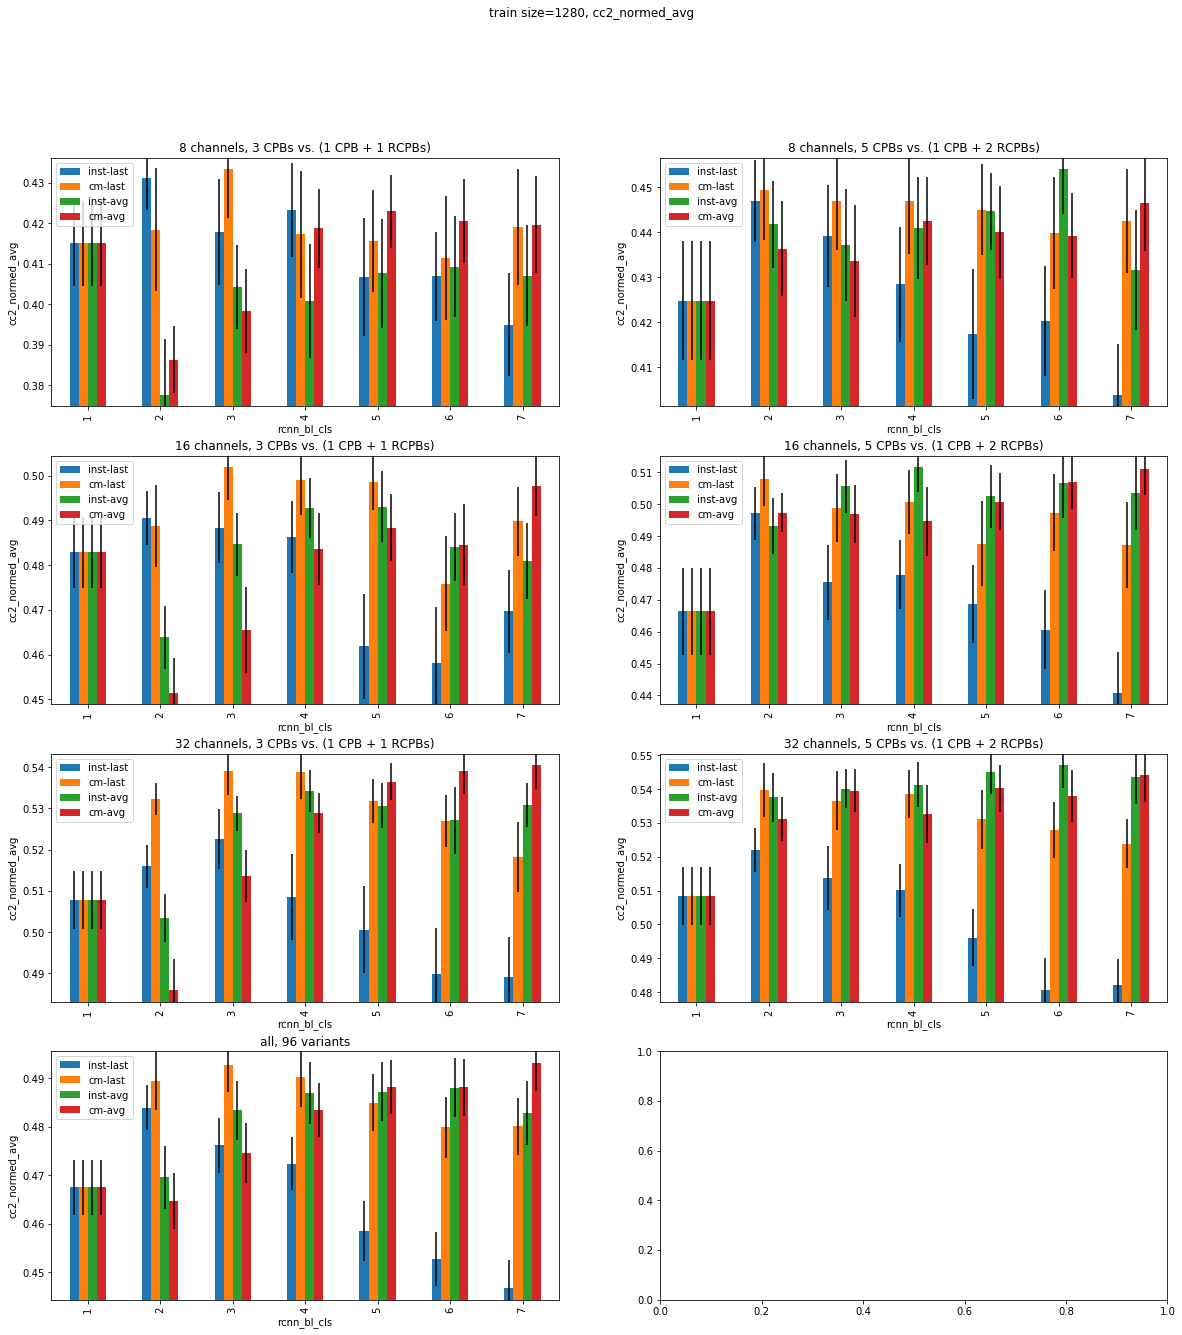

2560
(3216, 2)
seed=0, mean 0.5763460230443566 std 0.04724096089001875
seed=1, mean 0.5759845896656005 std 0.04860314691328289
corr 0.948545051287393
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.002870
                                poisson    3          32           1              0.003124
          True                  mse        3          32           1              0.001638
                                poisson    3          32           1              0.004913
softplus  False                 mse        3          32           1              0.000329
                                poisson    3          32           1              0.000045
          True                  mse        3          32           1              0.000319
                                poisson    3          32           1              0.000000
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          32           1              0.0
             

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.541211,0.541211,0.541211,0.541211
2,0.546669,0.548854,0.522170,0.522498
3,0.538890,0.553595,0.529745,0.537268
4,0.539106,0.544901,0.539141,0.541440
5,0.524191,0.540430,0.540969,0.539770
6,0.515209,0.536746,0.540393,0.544180
7,0.511978,0.537969,0.532856,0.543569


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.008%,1.412%,-3.518%,-3.458%
3,-0.429%,2.288%,-2.119%,-0.729%
4,-0.389%,0.682%,-0.383%,0.042%
5,-3.145%,-0.144%,-0.045%,-0.266%
6,-4.804%,-0.825%,-0.151%,0.549%
7,-5.401%,-0.599%,-1.544%,0.436%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.553814,0.553814,0.553814,0.553814
2,0.557689,0.571510,0.552437,0.554484
3,0.560728,0.565163,0.558250,0.558409
4,0.545299,0.566132,0.562802,0.564301
5,0.549901,0.558512,0.562126,0.562201
6,0.543936,0.563830,0.567679,0.561758
7,0.541979,0.559557,0.568306,0.560352


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.700%,3.195%,-0.249%,0.121%
3,1.248%,2.049%,0.801%,0.830%
4,-1.538%,2.224%,1.623%,1.893%
5,-0.707%,0.848%,1.501%,1.514%
6,-1.784%,1.808%,2.504%,1.434%
7,-2.137%,1.037%,2.617%,1.180%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.581026,0.581026,0.581026,0.581026
2,0.586832,0.591905,0.577444,0.560322
3,0.594916,0.600861,0.586098,0.582847
4,0.586997,0.592894,0.591177,0.588581
5,0.581754,0.592995,0.592819,0.587602
6,0.570356,0.590745,0.592541,0.590930
7,0.567988,0.584605,0.593032,0.596668


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.999%,1.872%,-0.617%,-3.563%
3,2.391%,3.414%,0.873%,0.313%
4,1.028%,2.043%,1.747%,1.300%
5,0.125%,2.060%,2.030%,1.132%
6,-1.836%,1.673%,1.982%,1.705%
7,-2.244%,0.616%,2.066%,2.692%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.582336,0.582336,0.582336,0.582336
2,0.600718,0.603496,0.595721,0.597582
3,0.593918,0.599875,0.601349,0.599675
4,0.587709,0.600496,0.602478,0.601660
5,0.578422,0.598394,0.605488,0.604785
6,0.569242,0.600086,0.607091,0.604361
7,0.575183,0.595460,0.605361,0.606305


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.157%,3.634%,2.298%,2.618%
3,1.989%,3.012%,3.265%,2.978%
4,0.923%,3.119%,3.459%,3.318%
5,-0.672%,2.758%,3.976%,3.855%
6,-2.248%,3.048%,4.251%,3.782%
7,-1.228%,2.254%,3.954%,4.116%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.599080,0.599080,0.599080,0.599080
2,0.602190,0.607974,0.593122,0.585916
3,0.612628,0.619650,0.612471,0.602086
4,0.607992,0.615425,0.615216,0.612359
5,0.603110,0.617348,0.622346,0.616775
6,0.596832,0.618018,0.621373,0.621115
7,0.591663,0.614114,0.621606,0.623558


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.519%,1.484%,-0.995%,-2.197%
3,2.261%,3.434%,2.235%,0.502%
4,1.488%,2.728%,2.693%,2.217%
5,0.673%,3.049%,3.884%,2.954%
6,-0.375%,3.161%,3.721%,3.678%
7,-1.238%,2.510%,3.760%,4.086%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.609539,0.609539,0.609539,0.609539
2,0.612742,0.618076,0.615453,0.614210
3,0.604238,0.624275,0.622783,0.623307
4,0.603672,0.625911,0.627331,0.625204
5,0.595592,0.620730,0.630350,0.627203
6,0.592641,0.623856,0.632866,0.629437
7,0.596307,0.626193,0.632013,0.631380


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.525%,1.400%,0.970%,0.766%
3,-0.870%,2.418%,2.173%,2.259%
4,-0.963%,2.686%,2.919%,2.570%
5,-2.288%,1.836%,3.414%,2.898%
6,-2.772%,2.349%,3.827%,3.264%
7,-2.171%,2.732%,3.687%,3.583%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.577834,0.577834,0.577834,0.577834
2,0.584473,0.590302,0.576058,0.572502
3,0.584220,0.593903,0.585116,0.583932
4,0.578462,0.590960,0.589691,0.588924
5,0.572161,0.588068,0.592350,0.589723
6,0.564703,0.588880,0.593657,0.591964
7,0.564183,0.586316,0.592196,0.593639


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.149%,2.158%,-0.308%,-0.923%
3,1.105%,2.781%,1.260%,1.055%
4,0.109%,2.271%,2.052%,1.919%
5,-0.982%,1.771%,2.512%,2.057%
6,-2.273%,1.912%,2.738%,2.445%
7,-2.363%,1.468%,2.485%,2.735%


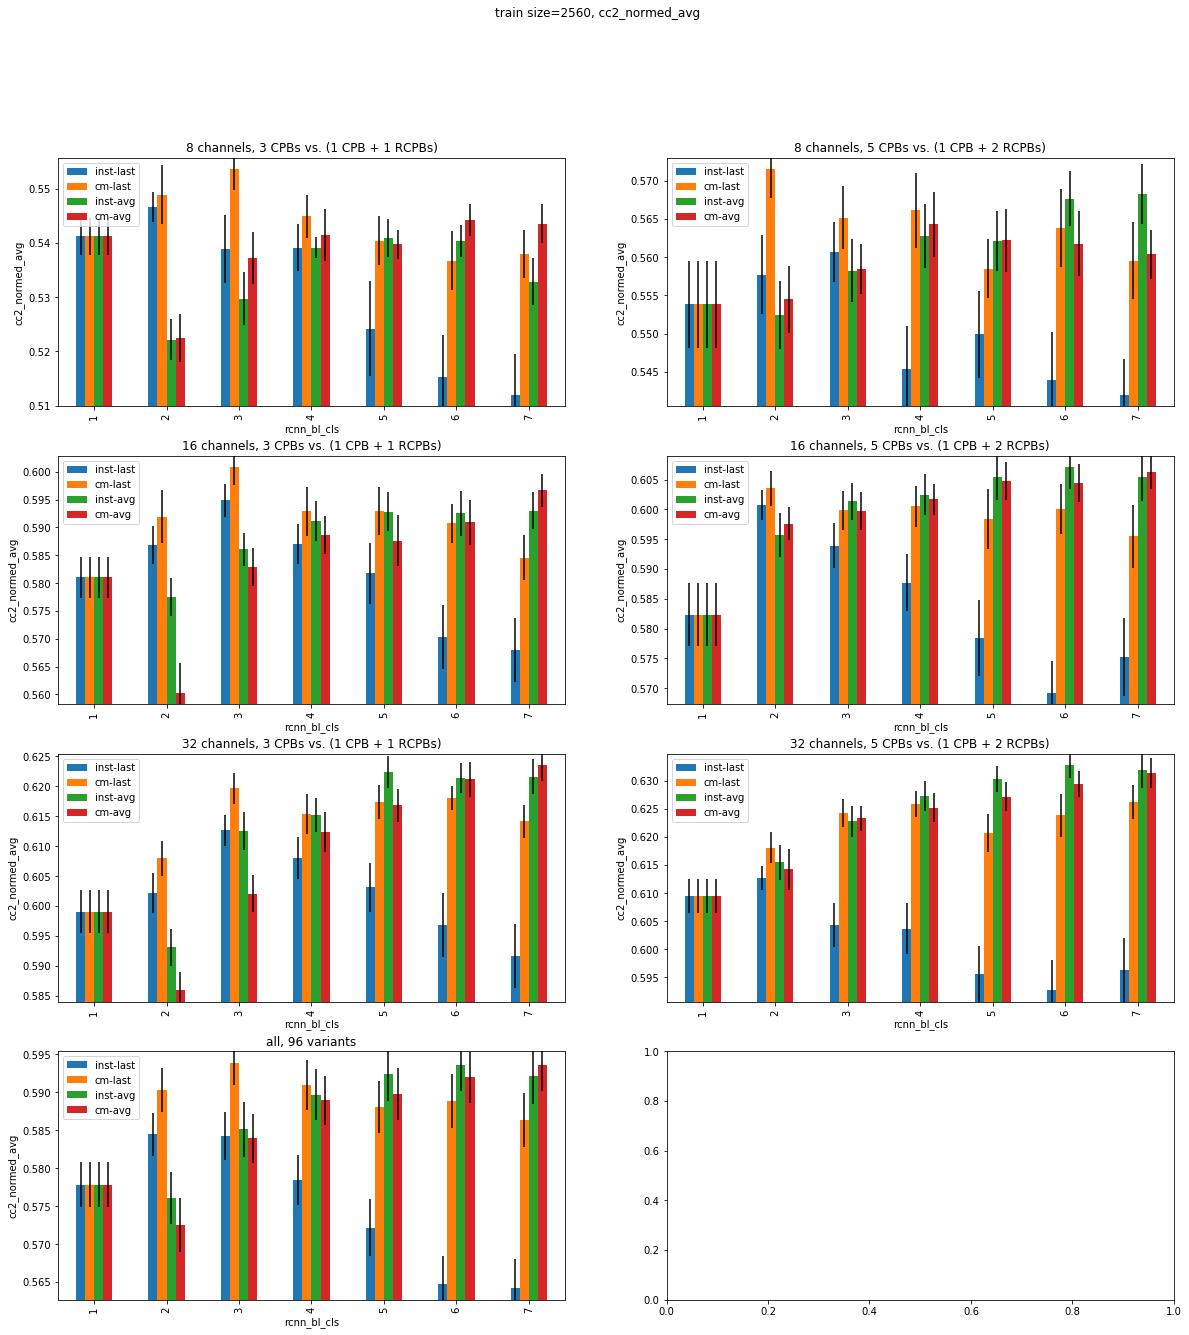

5120
(3216, 2)
seed=0, mean 0.6249498376716323 std 0.04372959035502312
seed=1, mean 0.6250958435688958 std 0.04312810085131611
corr 0.9649037567314487
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.000315
                                poisson    3          32           1              0.001693
          True                  mse        3          32           1              0.000552
                                poisson    3          32           1              0.006867
softplus  False                 mse        3          32           1              0.000537
                                poisson    3          32           1              0.000550
          True                  mse        3          32           1              0.001464
                                poisson    3          32           1              0.000000
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          32           1              0.0
             

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.597854,0.597854,0.597854,0.597854
2,0.601411,0.599718,0.575044,0.571330
3,0.599703,0.594298,0.586611,0.579767
4,0.601002,0.587709,0.588356,0.581352
5,0.588349,0.593430,0.593338,0.582486
6,0.583136,0.589787,0.596449,0.589855
7,0.575872,0.583132,0.589993,0.594689


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.595%,0.312%,-3.815%,-4.437%
3,0.309%,-0.595%,-1.881%,-3.025%
4,0.527%,-1.697%,-1.589%,-2.760%
5,-1.590%,-0.740%,-0.755%,-2.570%
6,-2.462%,-1.349%,-0.235%,-1.338%
7,-3.677%,-2.462%,-1.315%,-0.529%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.617661,0.617661,0.617661,0.617661
2,0.617469,0.615726,0.608474,0.608391
3,0.616089,0.617744,0.614401,0.610849
4,0.608500,0.618837,0.614610,0.612320
5,0.605037,0.619189,0.617663,0.612500
6,0.608244,0.611939,0.615363,0.616518
7,0.602513,0.613918,0.615294,0.620409


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,-0.031%,-0.313%,-1.487%,-1.501%
3,-0.255%,0.014%,-0.528%,-1.103%
4,-1.483%,0.191%,-0.494%,-0.865%
5,-2.044%,0.247%,0.000%,-0.836%
6,-1.525%,-0.926%,-0.372%,-0.185%
7,-2.452%,-0.606%,-0.383%,0.445%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.629986,0.629986,0.629986,0.629986
2,0.627236,0.628541,0.609111,0.607343
3,0.640220,0.638119,0.626182,0.618705
4,0.632558,0.639166,0.632852,0.624665
5,0.633227,0.638459,0.639573,0.630917
6,0.624750,0.640481,0.639750,0.634958
7,0.624610,0.635362,0.641083,0.637412


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,-0.437%,-0.229%,-3.314%,-3.594%
3,1.624%,1.291%,-0.604%,-1.791%
4,0.408%,1.457%,0.455%,-0.845%
5,0.514%,1.345%,1.522%,0.148%
6,-0.831%,1.666%,1.550%,0.789%
7,-0.853%,0.853%,1.761%,1.179%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.643496,0.643496,0.643496,0.643496
2,0.647005,0.648890,0.643236,0.642334
3,0.642189,0.652017,0.645633,0.644798
4,0.642533,0.650302,0.650740,0.649903
5,0.636136,0.650042,0.651895,0.649232
6,0.631851,0.648666,0.653923,0.653650
7,0.635522,0.649446,0.654098,0.654181


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.545%,0.838%,-0.040%,-0.181%
3,-0.203%,1.324%,0.332%,0.202%
4,-0.150%,1.058%,1.126%,0.996%
5,-1.144%,1.017%,1.305%,0.891%
6,-1.810%,0.804%,1.620%,1.578%
7,-1.239%,0.925%,1.648%,1.660%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.643171,0.643171,0.643171,0.643171
2,0.644461,0.645926,0.629896,0.624359
3,0.658561,0.659549,0.648412,0.639433
4,0.657381,0.659905,0.657726,0.647748
5,0.655673,0.659964,0.663157,0.655283
6,0.653698,0.658089,0.664211,0.659399
7,0.652783,0.656679,0.665985,0.660635


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.201%,0.428%,-2.064%,-2.925%
3,2.393%,2.546%,0.815%,-0.581%
4,2.209%,2.602%,2.263%,0.712%
5,1.944%,2.611%,3.107%,1.883%
6,1.637%,2.319%,3.271%,2.523%
7,1.495%,2.100%,3.547%,2.715%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.661392,0.661392,0.661392,0.661392
2,0.663316,0.664150,0.661451,0.657188
3,0.659468,0.668583,0.668680,0.663766
4,0.658973,0.670497,0.671150,0.667739
5,0.656716,0.669996,0.672722,0.671353
6,0.657335,0.673047,0.676295,0.672169
7,0.654195,0.670638,0.675935,0.674013


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.291%,0.417%,0.009%,-0.636%
3,-0.291%,1.087%,1.102%,0.359%
4,-0.366%,1.377%,1.475%,0.960%
5,-0.707%,1.301%,1.713%,1.506%
6,-0.613%,1.762%,2.253%,1.629%
7,-1.088%,1.398%,2.199%,1.908%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.632260,0.632260,0.632260,0.632260
2,0.633483,0.633825,0.621202,0.618491
3,0.636038,0.638385,0.631653,0.626220
4,0.633491,0.637736,0.635906,0.630621
5,0.629190,0.638513,0.639725,0.633628
6,0.626503,0.637002,0.640999,0.637758
7,0.624249,0.634862,0.640398,0.640223


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.193%,0.248%,-1.749%,-2.178%
3,0.598%,0.969%,-0.096%,-0.955%
4,0.195%,0.866%,0.577%,-0.259%
5,-0.486%,0.989%,1.181%,0.216%
6,-0.911%,0.750%,1.382%,0.870%
7,-1.267%,0.412%,1.287%,1.260%


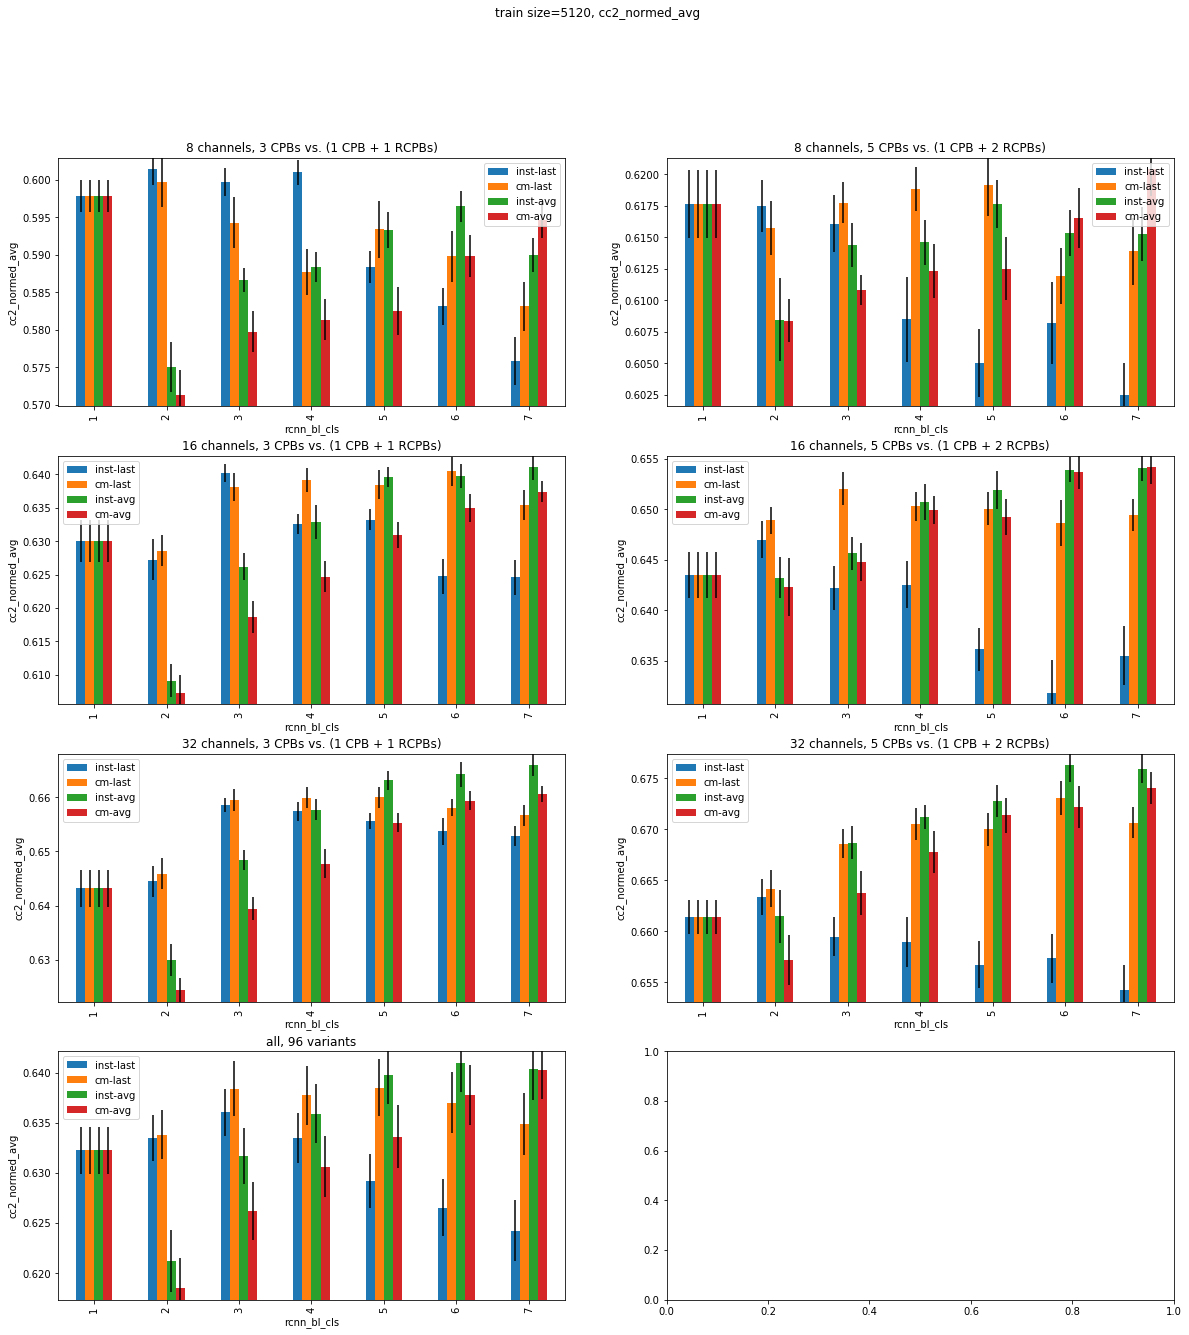

cc2_raw_avg
1280
(3216, 2)
seed=0, mean 0.2187032141961014 std 0.033974963560037805
seed=1, mean 0.21931103211492267 std 0.033676029626269165
corr 0.9067916713460483
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type 

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.002092
                                poisson    2          32           1              0.001146
          True                  mse        2          32           1              0.000975
                                poisson    2          32           1              0.006920
softplus  False                 mse        2          32           1              0.000938
                                poisson    2          32           1              0.001009
          True                  mse        2          32           1              0.000191
                                poisson    2          32           1              0.001259
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.001387
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.195444,0.195444,0.195444,0.195444
2,0.202867,0.196832,0.178326,0.183075
3,0.196228,0.203760,0.190748,0.188177
4,0.198432,0.195701,0.188492,0.197646
5,0.190664,0.195074,0.191879,0.199243
6,0.190425,0.192756,0.192416,0.198170
7,0.184830,0.196189,0.191615,0.197252


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.798%,0.711%,-8.758%,-6.328%
3,0.401%,4.255%,-2.403%,-3.718%
4,1.529%,0.132%,-3.557%,1.127%
5,-2.445%,-0.189%,-1.824%,1.944%
6,-2.568%,-1.375%,-1.549%,1.395%
7,-5.430%,0.382%,-1.959%,0.925%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.198997,0.198997,0.198997,0.198997
2,0.209854,0.211124,0.207862,0.205503
3,0.205837,0.209890,0.205750,0.203877
4,0.200493,0.209933,0.207432,0.208136
5,0.195754,0.208449,0.208825,0.206730
6,0.196602,0.206004,0.213176,0.206278
7,0.188929,0.207403,0.203077,0.209789


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,5.456%,6.094%,4.455%,3.269%
3,3.437%,5.474%,3.393%,2.452%
4,0.752%,5.495%,4.239%,4.592%
5,-1.630%,4.749%,4.938%,3.886%
6,-1.204%,3.521%,7.125%,3.658%
7,-5.059%,4.224%,2.050%,5.423%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.226267,0.226267,0.226267,0.226267
2,0.229793,0.228996,0.218631,0.213032
3,0.228949,0.235234,0.228063,0.219013
4,0.227687,0.233697,0.231127,0.227134
5,0.215613,0.233362,0.231224,0.229111
6,0.214145,0.222928,0.227065,0.227265
7,0.219393,0.229256,0.225615,0.233323


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.558%,1.206%,-3.375%,-5.849%
3,1.186%,3.963%,0.794%,-3.206%
4,0.627%,3.284%,2.148%,0.383%
5,-4.709%,3.136%,2.191%,1.257%
6,-5.358%,-1.476%,0.353%,0.441%
7,-3.038%,1.321%,-0.288%,3.118%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.217901,0.217901,0.217901,0.217901
2,0.232207,0.237736,0.231357,0.233052
3,0.222361,0.233609,0.237059,0.233059
4,0.222861,0.234277,0.239513,0.232022
5,0.218678,0.228003,0.235437,0.234966
6,0.215175,0.232863,0.237005,0.237501
7,0.205943,0.227727,0.235692,0.239373


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,6.565%,9.103%,6.175%,6.953%
3,2.047%,7.209%,8.792%,6.957%
4,2.277%,7.516%,9.918%,6.480%
5,0.357%,4.636%,8.048%,7.832%
6,-1.251%,6.867%,8.768%,8.995%
7,-5.488%,4.510%,8.165%,9.854%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.236903,0.236903,0.236903,0.236903
2,0.240690,0.248296,0.236094,0.228065
3,0.243696,0.251399,0.247030,0.240454
4,0.237420,0.251324,0.249382,0.247420
5,0.233565,0.248401,0.248020,0.250290
6,0.228265,0.245873,0.246177,0.251388
7,0.228221,0.241657,0.248281,0.252147


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.598%,4.809%,-0.341%,-3.731%
3,2.867%,6.119%,4.275%,1.499%
4,0.218%,6.087%,5.267%,4.439%
5,-1.409%,4.853%,4.692%,5.651%
6,-3.646%,3.786%,3.914%,6.114%
7,-3.665%,2.007%,4.803%,6.435%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.236621,0.236621,0.236621,0.236621
2,0.242833,0.251298,0.250433,0.247591
3,0.239037,0.249916,0.251659,0.251329
4,0.236885,0.250756,0.252073,0.248208
5,0.231016,0.247111,0.254101,0.251641
6,0.223771,0.245561,0.254796,0.250718
7,0.224657,0.244065,0.253064,0.253210


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,2.625%,6.203%,5.837%,4.636%
3,1.021%,5.619%,6.355%,6.216%
4,0.111%,5.974%,6.530%,4.897%
5,-2.369%,4.433%,7.387%,6.347%
6,-5.431%,3.778%,7.681%,5.958%
7,-5.057%,3.146%,6.949%,7.011%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.218689,0.218689,0.218689,0.218689
2,0.226374,0.229047,0.220451,0.218387
3,0.222685,0.230635,0.226718,0.222652
4,0.220630,0.229281,0.228003,0.226761
5,0.214215,0.226733,0.228248,0.228663
6,0.211397,0.224331,0.228439,0.228553
7,0.208662,0.224383,0.226224,0.230849


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.514%,4.737%,0.806%,-0.138%
3,1.827%,5.462%,3.672%,1.812%
4,0.887%,4.844%,4.259%,3.691%
5,-2.046%,3.678%,4.371%,4.561%
6,-3.334%,2.580%,4.459%,4.511%
7,-4.585%,2.604%,3.446%,5.560%


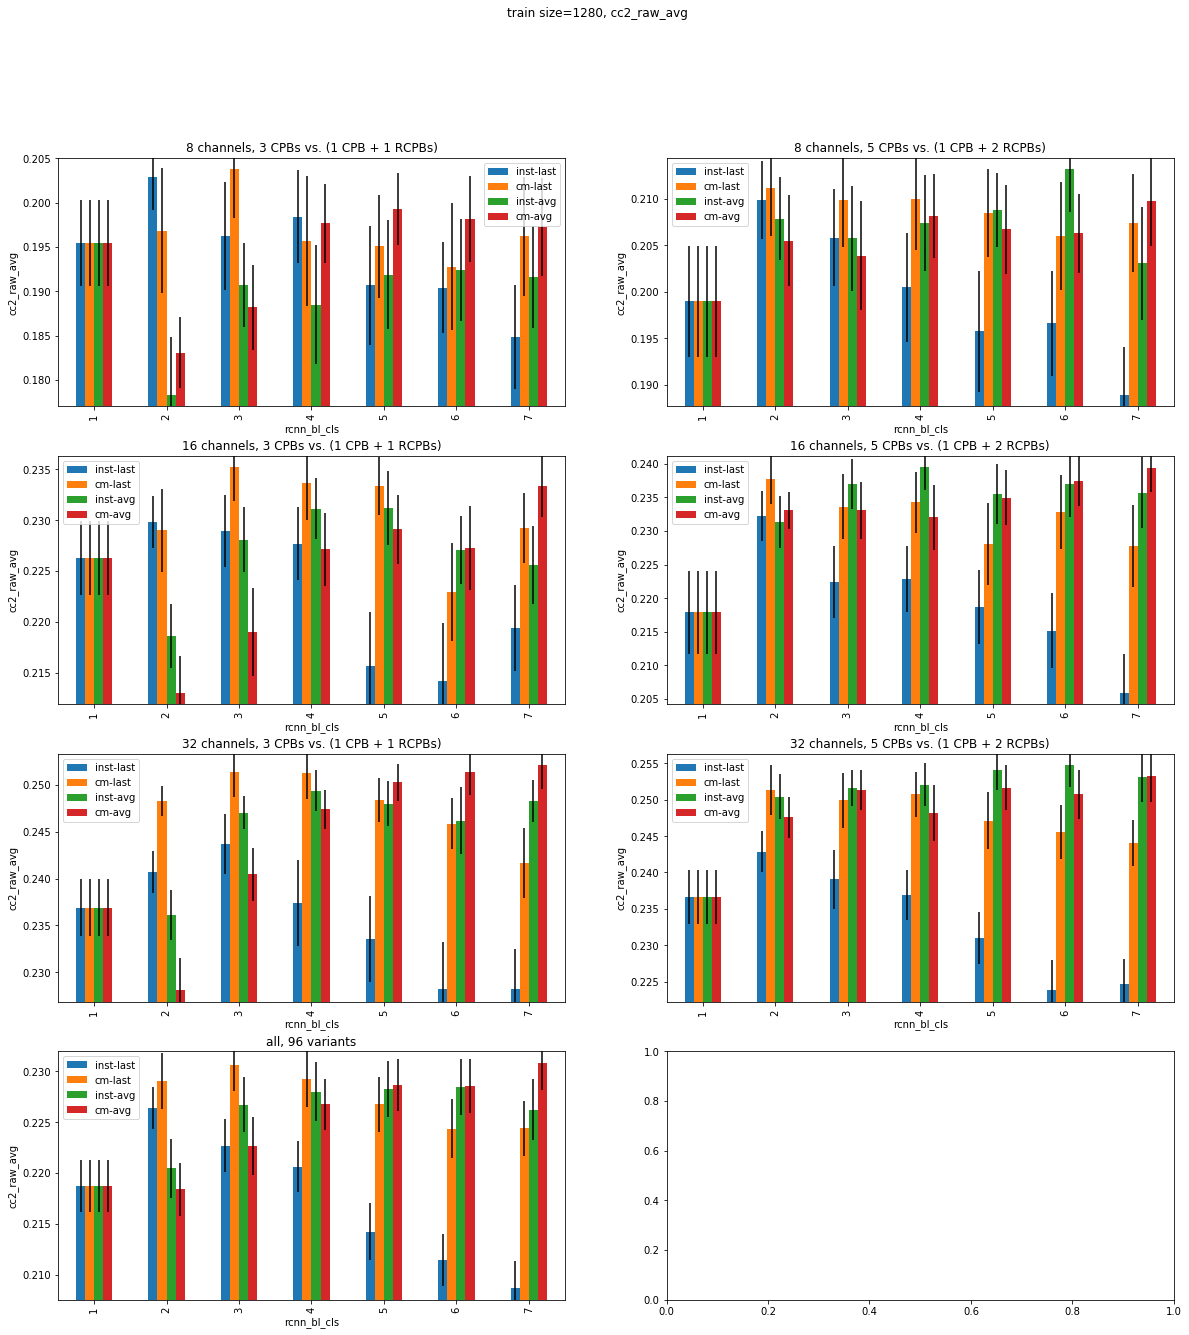

2560
(3216, 2)
seed=0, mean 0.267225579633347 std 0.0209602476564602
seed=1, mean 0.26696789464154574 std 0.021584718489932396
corr 0.9476921625929116
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.000405
                                poisson    2          32           1              0.014552
          True                  mse        2          32           1              0.000240
                                poisson    2          32           1              0.002740
softplus  False                 mse        2          32           1              0.000467
                                poisson    2          32           1              0.001505
          True                  mse        2          32           1              0.000639
                                poisson    2          32           1              0.000700
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.001116
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.252162,0.252162,0.252162,0.252162
2,0.254493,0.255390,0.243892,0.244194
3,0.250833,0.257595,0.247337,0.250612
4,0.250904,0.253553,0.251743,0.252273
5,0.244029,0.251481,0.252118,0.251819
6,0.239841,0.249801,0.252046,0.253722
7,0.238166,0.250044,0.248267,0.253340


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.925%,1.280%,-3.280%,-3.160%
3,-0.527%,2.155%,-1.913%,-0.615%
4,-0.499%,0.552%,-0.166%,0.044%
5,-3.225%,-0.270%,-0.017%,-0.136%
6,-4.886%,-0.936%,-0.046%,0.619%
7,-5.550%,-0.840%,-1.544%,0.467%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.257290,0.257290,0.257290,0.257290
2,0.259020,0.265670,0.257199,0.258003
3,0.260487,0.262560,0.259867,0.259870
4,0.253486,0.262947,0.261861,0.262642
5,0.255763,0.259568,0.261456,0.261376
6,0.252675,0.261922,0.264131,0.261411
7,0.252037,0.260364,0.264345,0.260748


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.672%,3.257%,-0.035%,0.277%
3,1.243%,2.048%,1.002%,1.003%
4,-1.478%,2.199%,1.777%,2.080%
5,-0.593%,0.886%,1.619%,1.588%
6,-1.793%,1.800%,2.659%,1.602%
7,-2.042%,1.195%,2.742%,1.344%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.269119,0.269119,0.269119,0.269119
2,0.271425,0.273725,0.267378,0.260304
3,0.275444,0.277829,0.271800,0.270025
4,0.271473,0.274649,0.273973,0.272617
5,0.269541,0.274363,0.274503,0.272398
6,0.264596,0.273538,0.275062,0.273957
7,0.263555,0.270815,0.275097,0.276131


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.857%,1.711%,-0.647%,-3.276%
3,2.350%,3.236%,0.996%,0.337%
4,0.875%,2.055%,1.804%,1.300%
5,0.157%,1.948%,2.001%,1.218%
6,-1.681%,1.642%,2.208%,1.798%
7,-2.067%,0.630%,2.221%,2.606%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.269421,0.269421,0.269421,0.269421
2,0.277475,0.279394,0.275981,0.276857
3,0.274713,0.277733,0.278418,0.277579
4,0.271894,0.277997,0.279035,0.278375
5,0.267786,0.276741,0.280231,0.279981
6,0.263903,0.277818,0.280761,0.279941
7,0.266060,0.275660,0.280472,0.280704


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,2.989%,3.702%,2.435%,2.760%
3,1.964%,3.085%,3.339%,3.028%
4,0.918%,3.183%,3.568%,3.323%
5,-0.607%,2.717%,4.012%,3.920%
6,-2.048%,3.116%,4.209%,3.904%
7,-1.247%,2.316%,4.102%,4.188%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.276668,0.276668,0.276668,0.276668
2,0.277935,0.280735,0.274500,0.271207
3,0.282708,0.285948,0.283012,0.278398
4,0.280806,0.283900,0.284270,0.282857
5,0.278773,0.285033,0.287486,0.284834
6,0.275982,0.285212,0.287028,0.286703
7,0.273766,0.283790,0.287196,0.287839


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.458%,1.470%,-0.784%,-1.974%
3,2.183%,3.354%,2.293%,0.625%
4,1.495%,2.614%,2.748%,2.237%
5,0.761%,3.023%,3.910%,2.952%
6,-0.248%,3.088%,3.745%,3.627%
7,-1.049%,2.574%,3.805%,4.038%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.281545,0.281545,0.281545,0.281545
2,0.282567,0.285266,0.284057,0.283413
3,0.279074,0.287783,0.287180,0.287542
4,0.278719,0.288782,0.289426,0.288429
5,0.275243,0.286467,0.290757,0.289130
6,0.274286,0.288030,0.292059,0.290484
7,0.275769,0.289018,0.291636,0.291311


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.363%,1.322%,0.892%,0.663%
3,-0.878%,2.216%,2.001%,2.130%
4,-1.004%,2.570%,2.799%,2.445%
5,-2.238%,1.748%,3.272%,2.694%
6,-2.578%,2.303%,3.734%,3.175%
7,-2.052%,2.654%,3.584%,3.469%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.267701,0.267701,0.267701,0.267701
2,0.270486,0.273363,0.267168,0.265663
3,0.270543,0.274908,0.271269,0.270671
4,0.267881,0.273638,0.273384,0.272866
5,0.265189,0.272276,0.274425,0.273256
6,0.261880,0.272720,0.275181,0.274369
7,0.261559,0.271615,0.274502,0.275012


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.040%,2.115%,-0.199%,-0.761%
3,1.062%,2.692%,1.333%,1.109%
4,0.067%,2.218%,2.123%,1.929%
5,-0.938%,1.709%,2.512%,2.075%
6,-2.174%,1.875%,2.794%,2.491%
7,-2.294%,1.462%,2.541%,2.731%


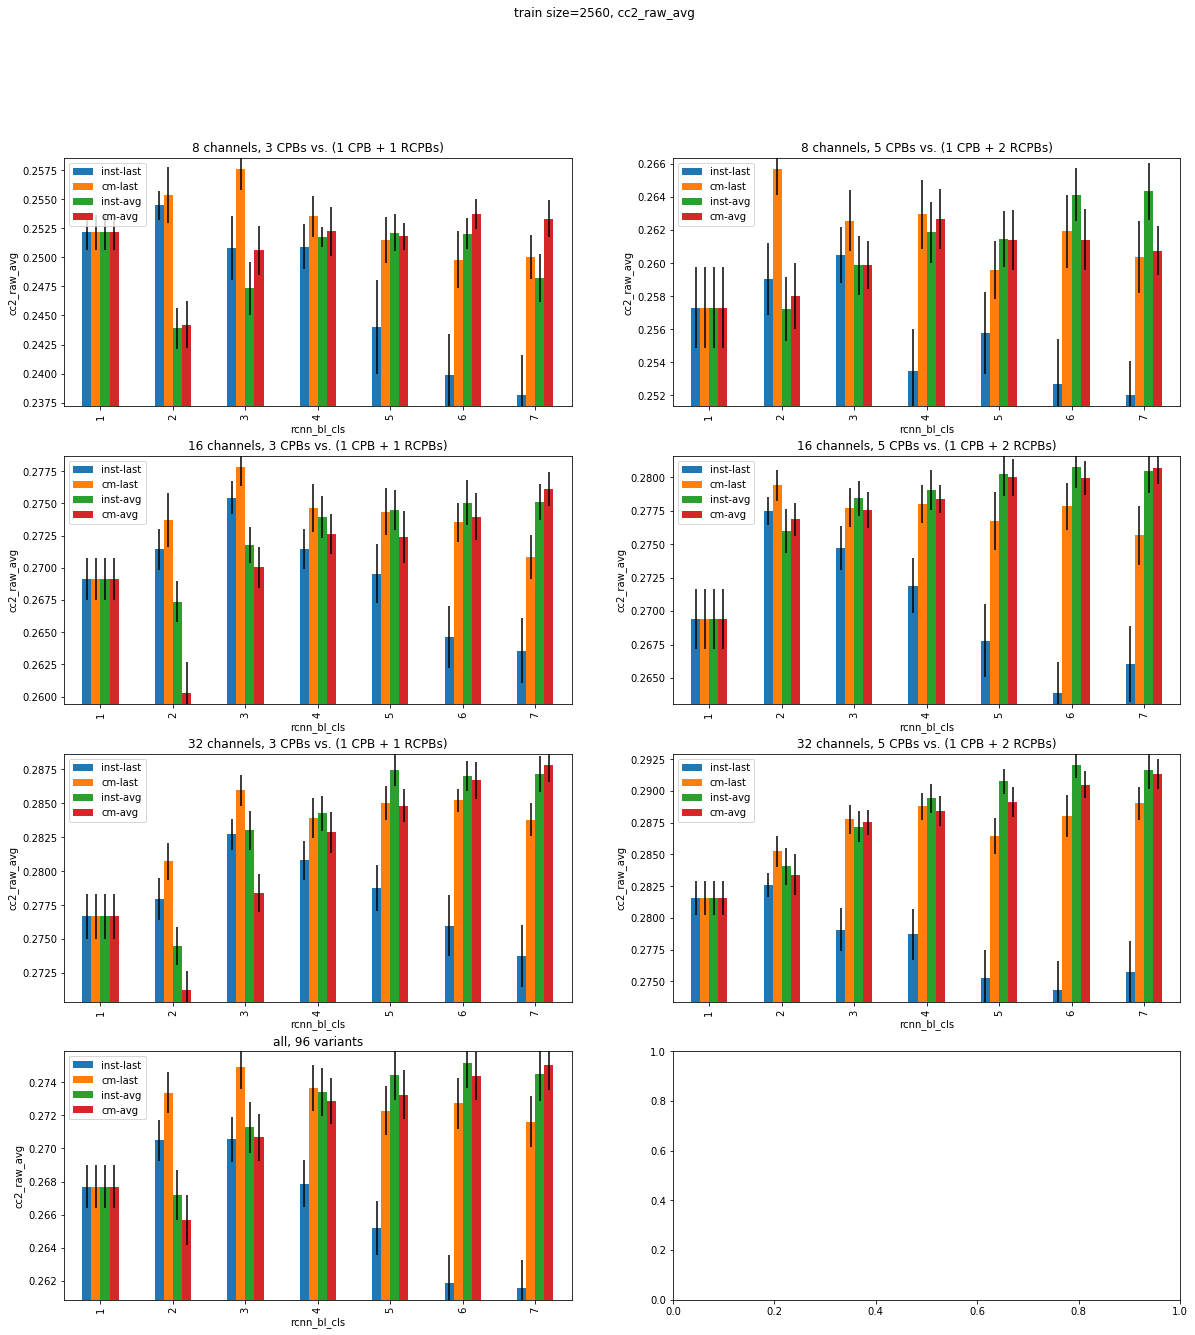

5120
(3216, 2)
seed=0, mean 0.28803783113147713 std 0.01952357587981238
seed=1, mean 0.28800409362073925 std 0.01928852906504997
corr 0.9660382660933857
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  o

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.001206
                                poisson    2          32           1              0.003027
          True                  mse        2          32           1              0.001019
                                poisson    2          32           1              0.000016
softplus  False                 mse        2          32           1              0.000560
                                poisson    2          32           1              0.000354
          True                  mse        2          32           1              0.001563
                                poisson    2          32           1              0.001198
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.000157
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.275823,0.275823,0.275823,0.275823
2,0.277443,0.276602,0.266038,0.264196
3,0.276875,0.274823,0.270999,0.268030
4,0.277298,0.271786,0.271907,0.268814
5,0.271957,0.274442,0.274185,0.269409
6,0.269788,0.272434,0.275392,0.272692
7,0.266590,0.269702,0.273022,0.274778


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.587%,0.282%,-3.548%,-4.216%
3,0.381%,-0.363%,-1.749%,-2.825%
4,0.535%,-1.464%,-1.420%,-2.541%
5,-1.402%,-0.501%,-0.594%,-2.326%
6,-2.188%,-1.229%,-0.156%,-1.135%
7,-3.347%,-2.219%,-1.016%,-0.379%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.284821,0.284821,0.284821,0.284821
2,0.284879,0.284059,0.280820,0.280545
3,0.284200,0.285236,0.283702,0.281892
4,0.281165,0.285632,0.283842,0.282792
5,0.279599,0.285698,0.285145,0.283116
6,0.280834,0.282684,0.284177,0.284732
7,0.278141,0.283759,0.284153,0.286362


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.020%,-0.267%,-1.405%,-1.501%
3,-0.218%,0.145%,-0.393%,-1.029%
4,-1.284%,0.285%,-0.344%,-0.712%
5,-1.834%,0.308%,0.114%,-0.599%
6,-1.400%,-0.750%,-0.226%,-0.031%
7,-2.346%,-0.373%,-0.235%,0.541%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.289753,0.289753,0.289753,0.289753
2,0.288179,0.289280,0.280884,0.279883
3,0.294579,0.293834,0.288512,0.285100
4,0.290980,0.294140,0.291580,0.287929
5,0.291602,0.293990,0.294572,0.290640
6,0.287985,0.294839,0.294645,0.292448
7,0.287793,0.292639,0.295471,0.293540


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,-0.543%,-0.163%,-3.061%,-3.406%
3,1.666%,1.408%,-0.428%,-1.606%
4,0.423%,1.514%,0.631%,-0.629%
5,0.638%,1.462%,1.663%,0.306%
6,-0.610%,1.755%,1.688%,0.930%
7,-0.676%,0.996%,1.973%,1.307%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.296164,0.296164,0.296164,0.296164
2,0.297857,0.298609,0.295979,0.295549
3,0.295682,0.300084,0.297077,0.296722
4,0.296045,0.299209,0.299538,0.299066
5,0.293021,0.299277,0.299969,0.298680
6,0.291098,0.298709,0.300773,0.300677
7,0.292657,0.298943,0.300984,0.301016


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.572%,0.826%,-0.062%,-0.207%
3,-0.163%,1.324%,0.308%,0.188%
4,-0.040%,1.028%,1.139%,0.980%
5,-1.061%,1.051%,1.285%,0.850%
6,-1.711%,0.859%,1.556%,1.524%
7,-1.184%,0.938%,1.628%,1.638%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.295708,0.295708,0.295708,0.295708
2,0.296272,0.297114,0.290016,0.287509
3,0.302617,0.303319,0.298468,0.294406
4,0.302133,0.303479,0.302575,0.298117
5,0.301560,0.303630,0.305047,0.301489
6,0.300534,0.302704,0.305524,0.303409
7,0.300155,0.302185,0.306131,0.303997


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.191%,0.475%,-1.925%,-2.773%
3,2.336%,2.574%,0.933%,-0.440%
4,2.173%,2.628%,2.322%,0.815%
5,1.979%,2.679%,3.158%,1.955%
6,1.632%,2.366%,3.319%,2.604%
7,1.504%,2.190%,3.525%,2.803%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.304112,0.304112,0.304112,0.304112
2,0.304909,0.305286,0.304000,0.302019
3,0.303080,0.307347,0.307270,0.305026
4,0.303177,0.308276,0.308455,0.306950
5,0.302138,0.308184,0.309286,0.308645
6,0.302520,0.309690,0.310901,0.308877
7,0.301066,0.308446,0.310692,0.309720


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.262%,0.386%,-0.037%,-0.688%
3,-0.339%,1.064%,1.038%,0.301%
4,-0.307%,1.369%,1.428%,0.933%
5,-0.649%,1.339%,1.701%,1.491%
6,-0.523%,1.834%,2.233%,1.567%
7,-1.002%,1.425%,2.164%,1.844%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.291064,0.291064,0.291064,0.291064
2,0.291590,0.291825,0.286290,0.284950
3,0.292839,0.294107,0.291005,0.288529
4,0.291800,0.293754,0.292983,0.290611
5,0.289980,0.294204,0.294701,0.291996
6,0.288793,0.293510,0.295236,0.293806
7,0.287734,0.292612,0.295075,0.294902


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.181%,0.262%,-1.640%,-2.100%
3,0.610%,1.046%,-0.020%,-0.871%
4,0.253%,0.924%,0.659%,-0.155%
5,-0.372%,1.079%,1.250%,0.320%
6,-0.780%,0.840%,1.433%,0.942%
7,-1.144%,0.532%,1.378%,1.319%


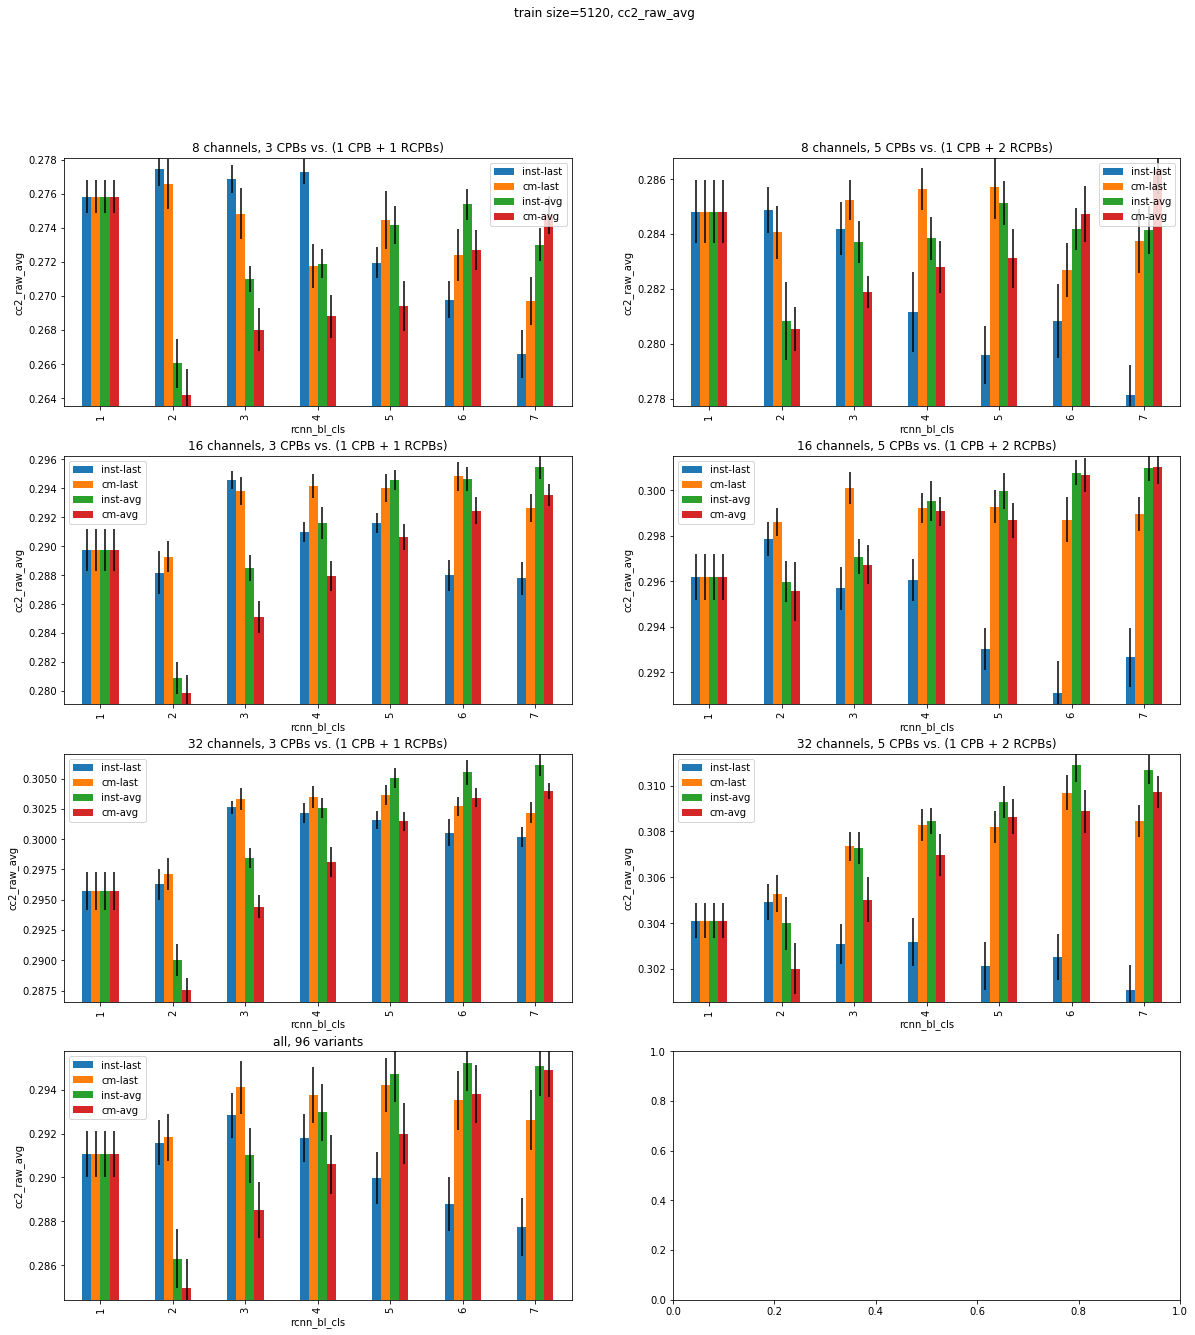

cc_raw_avg
1280
(3216, 2)
seed=0, mean 0.44037252387819825 std 0.04329890525358955
seed=1, mean 0.44133638497812233 std 0.04228527333686278
corr 0.8998393214849904
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  n

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.002192
                                poisson    2          32           1              0.001320
          True                  mse        2          32           1              0.000855
                                poisson    2          32           1              0.008247
softplus  False                 mse        2          32           1              0.001202
                                poisson    2          32           1              0.001130
          True                  mse        2          32           1              0.000806
                                poisson    2          32           1              0.001465
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.001720
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.414633,0.414633,0.414633,0.414633
2,0.423376,0.412149,0.388084,0.395923
3,0.415836,0.422504,0.405961,0.402583
4,0.418334,0.412759,0.402804,0.414500
5,0.408562,0.412200,0.407606,0.416819
6,0.409487,0.409588,0.409002,0.415256
7,0.402677,0.414375,0.407413,0.414555


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,2.109%,-0.599%,-6.403%,-4.513%
3,0.290%,1.898%,-2.091%,-2.906%
4,0.893%,-0.452%,-2.853%,-0.032%
5,-1.464%,-0.587%,-1.695%,0.527%
6,-1.241%,-1.217%,-1.358%,0.150%
7,-2.884%,-0.062%,-1.741%,-0.019%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.419671,0.419671,0.419671,0.419671
2,0.432080,0.432827,0.428757,0.425407
3,0.428037,0.431618,0.426390,0.424338
4,0.421953,0.431620,0.428181,0.429284
5,0.415446,0.430524,0.430127,0.427831
6,0.417156,0.427560,0.435692,0.427293
7,0.408527,0.429200,0.423200,0.431364


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,2.957%,3.135%,2.165%,1.367%
3,1.994%,2.847%,1.601%,1.112%
4,0.544%,2.847%,2.028%,2.291%
5,-1.007%,2.586%,2.492%,1.944%
6,-0.599%,1.880%,3.817%,1.816%
7,-2.655%,2.271%,0.841%,2.786%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.451497,0.451497,0.451497,0.451497
2,0.455386,0.452724,0.440138,0.432795
3,0.453983,0.459231,0.450431,0.440103
4,0.453024,0.458301,0.455309,0.449910
5,0.439551,0.457837,0.454754,0.452391
6,0.437374,0.445935,0.450076,0.450329
7,0.444106,0.453578,0.448737,0.457503


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.861%,0.272%,-2.516%,-4.142%
3,0.551%,1.713%,-0.236%,-2.524%
4,0.338%,1.507%,0.844%,-0.351%
5,-2.646%,1.404%,0.722%,0.198%
6,-3.128%,-1.232%,-0.315%,-0.259%
7,-1.637%,0.461%,-0.611%,1.330%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.442165,0.442165,0.442165,0.442165
2,0.458806,0.463518,0.456061,0.458352
3,0.447386,0.458632,0.462477,0.458003
4,0.448397,0.460248,0.465293,0.456424
5,0.443473,0.452507,0.460634,0.459876
6,0.439197,0.458326,0.462680,0.463150
7,0.428075,0.452585,0.460832,0.465160


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,3.764%,4.829%,3.143%,3.661%
3,1.181%,3.724%,4.594%,3.582%
4,1.409%,4.090%,5.231%,3.225%
5,0.296%,2.339%,4.177%,4.006%
6,-0.671%,3.655%,4.640%,4.746%
7,-3.187%,2.357%,4.222%,5.201%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.464104,0.464104,0.464104,0.464104
2,0.468239,0.475424,0.460390,0.451523
3,0.471243,0.478480,0.473499,0.465836
4,0.463943,0.478402,0.476129,0.473478
5,0.459874,0.474685,0.474772,0.477119
6,0.454546,0.472077,0.472261,0.478734
7,0.453959,0.468360,0.474336,0.479396


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.891%,2.439%,-0.800%,-2.711%
3,1.538%,3.098%,2.024%,0.373%
4,-0.035%,3.081%,2.591%,2.020%
5,-0.911%,2.280%,2.299%,2.804%
6,-2.059%,1.718%,1.758%,3.152%
7,-2.186%,0.917%,2.205%,3.295%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.464441,0.464441,0.464441,0.464441
2,0.471320,0.479881,0.478842,0.475699
3,0.466929,0.478077,0.480065,0.479668
4,0.465446,0.479040,0.480277,0.476092
5,0.457925,0.475253,0.482329,0.479693
6,0.449702,0.473033,0.483228,0.478548
7,0.450063,0.471441,0.481188,0.481515


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.481%,3.324%,3.101%,2.424%
3,0.536%,2.936%,3.364%,3.279%
4,0.216%,3.143%,3.410%,2.509%
5,-1.403%,2.328%,3.851%,3.284%
6,-3.174%,1.850%,4.045%,3.037%
7,-3.096%,1.507%,3.606%,3.676%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.442752,0.442752,0.442752,0.442752
2,0.451534,0.452754,0.442045,0.439950
3,0.447236,0.454757,0.449804,0.445089
4,0.445183,0.453395,0.451332,0.449948
5,0.437472,0.450501,0.451704,0.452288
6,0.434577,0.447753,0.452156,0.452218
7,0.431234,0.448256,0.449284,0.454916


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.984%,2.259%,-0.160%,-0.633%
3,1.013%,2.712%,1.593%,0.528%
4,0.549%,2.404%,1.938%,1.625%
5,-1.192%,1.750%,2.022%,2.154%
6,-1.846%,1.130%,2.124%,2.138%
7,-2.601%,1.243%,1.475%,2.747%


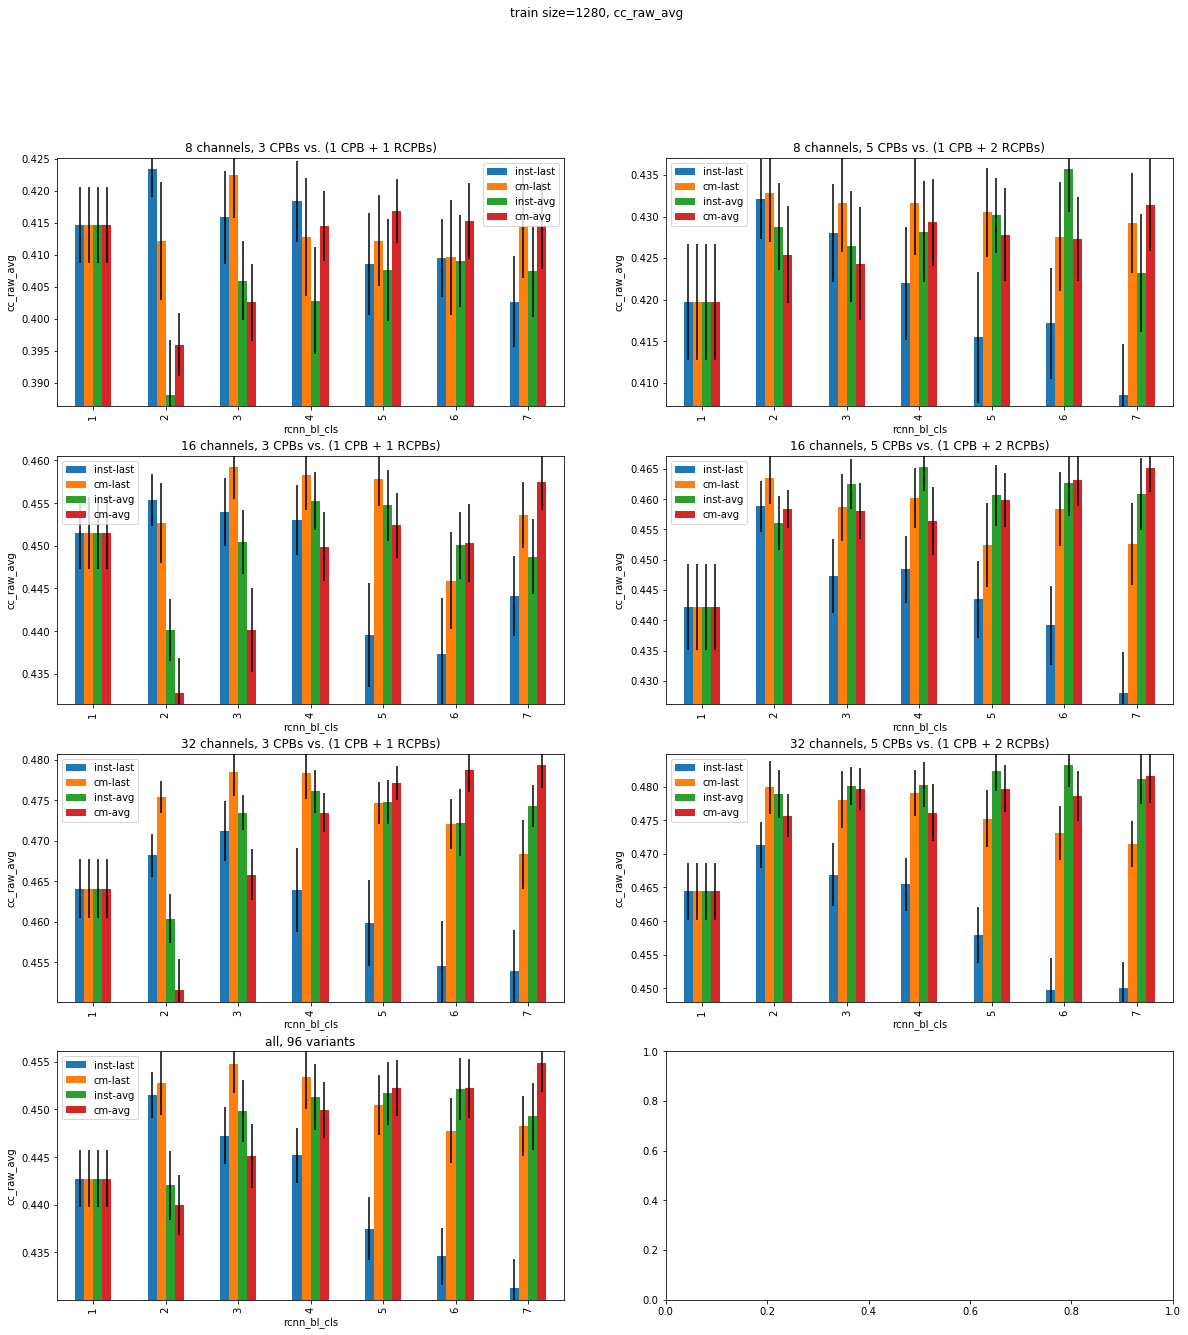

2560
(3216, 2)
seed=0, mean 0.49591780702680954 std 0.023252690592785435
seed=1, mean 0.4956969838770077 std 0.02410841313250322
corr 0.946824057804961
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  ou

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.000482
                                poisson    2          32           1              0.016413
          True                  mse        2          32           1              0.000310
                                poisson    2          32           1              0.002851
softplus  False                 mse        2          32           1              0.000085
                                poisson    2          32           1              0.002334
          True                  mse        2          32           1              0.000841
                                poisson    2          32           1              0.000181
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.001280
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.479628,0.479628,0.479628,0.479628
2,0.481975,0.482405,0.469641,0.470130
3,0.478573,0.485490,0.473939,0.477508
4,0.478634,0.480976,0.478745,0.479748
5,0.470847,0.478795,0.479562,0.478993
6,0.466690,0.476999,0.478863,0.481012
7,0.464474,0.477602,0.475148,0.480393


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.489%,0.579%,-2.082%,-1.980%
3,-0.220%,1.222%,-1.186%,-0.442%
4,-0.207%,0.281%,-0.184%,0.025%
5,-1.831%,-0.174%,-0.014%,-0.132%
6,-2.698%,-0.548%,-0.160%,0.289%
7,-3.160%,-0.423%,-0.934%,0.159%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.485607,0.485607,0.485607,0.485607
2,0.487099,0.493447,0.484491,0.485673
3,0.488698,0.490813,0.487365,0.487615
4,0.481669,0.491123,0.489552,0.490352
5,0.483612,0.487350,0.488886,0.489107
6,0.480557,0.490111,0.491748,0.488704
7,0.479695,0.487828,0.491928,0.488556


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.307%,1.614%,-0.230%,0.014%
3,0.637%,1.072%,0.362%,0.413%
4,-0.811%,1.136%,0.812%,0.977%
5,-0.411%,0.359%,0.675%,0.721%
6,-1.040%,0.928%,1.265%,0.638%
7,-1.218%,0.457%,1.302%,0.607%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.499063,0.499063,0.499063,0.499063
2,0.501719,0.503312,0.497053,0.488694
3,0.505408,0.507772,0.500874,0.499463
4,0.501466,0.503936,0.503224,0.502216
5,0.499007,0.503820,0.504114,0.501253
6,0.493482,0.503119,0.503740,0.502722
7,0.492202,0.500472,0.504172,0.505753


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.532%,0.851%,-0.403%,-2.078%
3,1.271%,1.745%,0.363%,0.080%
4,0.481%,0.976%,0.834%,0.632%
5,-0.011%,0.953%,1.012%,0.439%
6,-1.118%,0.813%,0.937%,0.733%
7,-1.375%,0.282%,1.024%,1.340%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.499371,0.499371,0.499371,0.499371
2,0.508398,0.509006,0.505718,0.506542
3,0.504934,0.507641,0.507970,0.507498
4,0.502236,0.507677,0.508245,0.508424
5,0.497275,0.506865,0.509932,0.509781
6,0.493151,0.507446,0.510600,0.509199
7,0.495672,0.505107,0.509476,0.510181


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,1.808%,1.930%,1.271%,1.436%
3,1.114%,1.656%,1.722%,1.628%
4,0.574%,1.663%,1.777%,1.813%
5,-0.420%,1.501%,2.115%,2.085%
6,-1.246%,1.617%,2.249%,1.968%
7,-0.741%,1.149%,2.024%,2.165%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.507680,0.507680,0.507680,0.507680
2,0.508903,0.510900,0.503927,0.500879
3,0.513819,0.516353,0.513082,0.508154
4,0.511276,0.514542,0.514355,0.513031
5,0.508959,0.515440,0.517432,0.515068
6,0.505970,0.515815,0.517323,0.516762
7,0.503121,0.513850,0.517260,0.518243


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.241%,0.634%,-0.739%,-1.340%
3,1.209%,1.708%,1.064%,0.093%
4,0.708%,1.352%,1.315%,1.054%
5,0.252%,1.528%,1.921%,1.455%
6,-0.337%,1.602%,1.899%,1.789%
7,-0.898%,1.215%,1.887%,2.081%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.512122,0.512122,0.512122,0.512122
2,0.514002,0.516326,0.514927,0.514265
3,0.509758,0.518832,0.518138,0.518455
4,0.509692,0.519394,0.520030,0.519110
5,0.505497,0.517133,0.521442,0.520096
6,0.503741,0.518356,0.522613,0.520922
7,0.505411,0.519332,0.521882,0.521893


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.367%,0.821%,0.548%,0.418%
3,-0.462%,1.310%,1.175%,1.237%
4,-0.475%,1.420%,1.544%,1.365%
5,-1.294%,0.978%,1.820%,1.557%
6,-1.636%,1.217%,2.049%,1.718%
7,-1.310%,1.408%,1.906%,1.908%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.497245,0.497245,0.497245,0.497245
2,0.500349,0.502566,0.495960,0.494364
3,0.500199,0.504484,0.500228,0.499782
4,0.497496,0.502942,0.502359,0.502147
5,0.494199,0.501567,0.503562,0.502383
6,0.490599,0.501974,0.504148,0.503220
7,0.490096,0.500698,0.503311,0.504170


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.624%,1.070%,-0.259%,-0.579%
3,0.594%,1.456%,0.600%,0.510%
4,0.050%,1.146%,1.028%,0.986%
5,-0.613%,0.869%,1.270%,1.033%
6,-1.337%,0.951%,1.388%,1.202%
7,-1.438%,0.694%,1.220%,1.393%


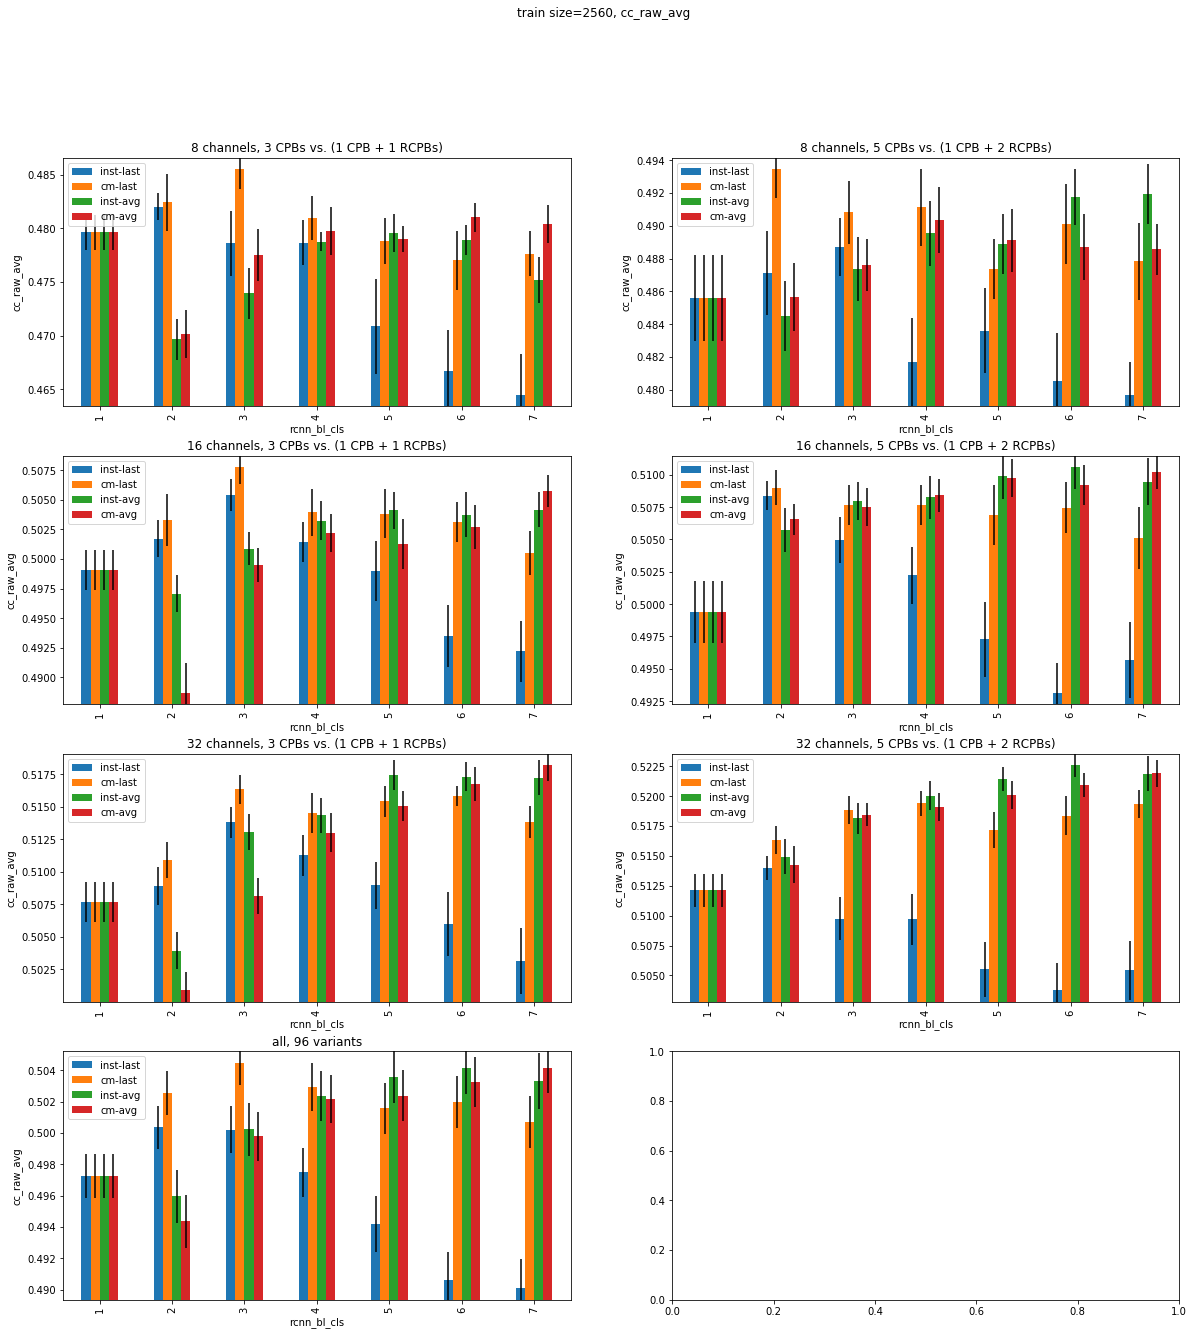

5120
(3216, 2)
seed=0, mean 0.5187073053878044 std 0.02072259162697186
seed=1, mean 0.5188321990957826 std 0.020434703045190863
corr 0.9646091595820017
(1608, 2)
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
softplus  False                 mse        4          2            1              0.0
                                poisson    4          2            1              0.0
          True                  mse        4          2            1              0.0
                                poisson    4          2            1              0.0
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  ou

act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        2          32           1              0.001405
                                poisson    2          32           1              0.003145
          True                  mse        2          32           1              0.000946
                                poisson    2          32           1              0.000469
softplus  False                 mse        2          32           1              0.001116
                                poisson    2          32           1              0.000033
          True                  mse        2          32           1              0.001397
                                poisson    2          32           1              0.000592
dtype: float64
act_fn    ff_1st_bn_before_act  loss_type  num_layer  out_channel  rcnn_bl_cls
relu      False                 mse        3          32           1              0.000184
        

,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,18049.0,18049.0,18049.0,18049.0
2,18049.0,18049.0,18049.0,18049.0
3,18065.0,18065.0,18065.0,18065.0
4,18081.0,18081.0,18081.0,18081.0
5,18097.0,18097.0,18097.0,18097.0
6,18113.0,18113.0,18113.0,18113.0
7,18129.0,18129.0,18129.0,18129.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.089%,0.089%,0.089%,0.089%
4,0.177%,0.177%,0.177%,0.177%
5,0.266%,0.266%,0.266%,0.266%
6,0.355%,0.355%,0.355%,0.355%
7,0.443%,0.443%,0.443%,0.443%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.506472,0.506472,0.506472,0.506472
2,0.508275,0.507232,0.496412,0.494701
3,0.507486,0.504786,0.502167,0.498515
4,0.508189,0.501403,0.502685,0.499015
5,0.501944,0.504095,0.504998,0.499532
6,0.499358,0.502533,0.506273,0.502942
7,0.495649,0.499119,0.502893,0.505319


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.356%,0.150%,-1.986%,-2.324%
3,0.200%,-0.333%,-0.850%,-1.571%
4,0.339%,-1.001%,-0.748%,-1.472%
5,-0.894%,-0.469%,-0.291%,-1.370%
6,-1.405%,-0.778%,-0.039%,-0.697%
7,-2.137%,-1.452%,-0.707%,-0.228%


8 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,19233.0,19233.0,19233.0,19233.0
2,19233.0,19233.0,19233.0,19233.0
3,19265.0,19265.0,19265.0,19265.0
4,19297.0,19297.0,19297.0,19297.0
5,19329.0,19329.0,19329.0,19329.0
6,19361.0,19361.0,19361.0,19361.0
7,19393.0,19393.0,19393.0,19393.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.166%,0.166%,0.166%,0.166%
4,0.333%,0.333%,0.333%,0.333%
5,0.499%,0.499%,0.499%,0.499%
6,0.666%,0.666%,0.666%,0.666%
7,0.832%,0.832%,0.832%,0.832%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.515563,0.515563,0.515563,0.515563
2,0.515481,0.514592,0.511493,0.511489
3,0.514558,0.515453,0.514016,0.512577
4,0.511379,0.515904,0.513961,0.512961
5,0.509500,0.516113,0.515385,0.513293
6,0.510944,0.512599,0.514360,0.515031
7,0.508395,0.513260,0.514119,0.516751


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,-0.016%,-0.188%,-0.789%,-0.790%
3,-0.195%,-0.021%,-0.300%,-0.579%
4,-0.812%,0.066%,-0.311%,-0.505%
5,-1.176%,0.107%,-0.034%,-0.440%
6,-0.896%,-0.575%,-0.233%,-0.103%
7,-1.390%,-0.447%,-0.280%,0.230%


16 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,22837.0,22837.0,22837.0,22837.0
2,22837.0,22837.0,22837.0,22837.0
3,22869.0,22869.0,22869.0,22869.0
4,22901.0,22901.0,22901.0,22901.0
5,22933.0,22933.0,22933.0,22933.0
6,22965.0,22965.0,22965.0,22965.0
7,22997.0,22997.0,22997.0,22997.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.140%,0.140%,0.140%,0.140%
4,0.280%,0.280%,0.280%,0.280%
5,0.420%,0.420%,0.420%,0.420%
6,0.560%,0.560%,0.560%,0.560%
7,0.701%,0.701%,0.701%,0.701%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.521688,0.521688,0.521688,0.521688
2,0.520192,0.521051,0.512474,0.511599
3,0.525910,0.524957,0.519870,0.516725
4,0.522474,0.525608,0.522973,0.519420
5,0.522799,0.525192,0.525792,0.522172
6,0.518942,0.526030,0.525727,0.523896
7,0.518761,0.523417,0.526499,0.524876


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,-0.287%,-0.122%,-1.766%,-1.934%
3,0.809%,0.627%,-0.348%,-0.951%
4,0.151%,0.751%,0.246%,-0.435%
5,0.213%,0.672%,0.787%,0.093%
6,-0.526%,0.832%,0.774%,0.423%
7,-0.561%,0.331%,0.922%,0.611%


16 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,27509.0,27509.0,27509.0,27509.0
2,27509.0,27509.0,27509.0,27509.0
3,27573.0,27573.0,27573.0,27573.0
4,27637.0,27637.0,27637.0,27637.0
5,27701.0,27701.0,27701.0,27701.0
6,27765.0,27765.0,27765.0,27765.0
7,27829.0,27829.0,27829.0,27829.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.233%,0.233%,0.233%,0.233%
4,0.465%,0.465%,0.465%,0.465%
5,0.698%,0.698%,0.698%,0.698%
6,0.931%,0.931%,0.931%,0.931%
7,1.163%,1.163%,1.163%,1.163%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.527443,0.527443,0.527443,0.527443
2,0.529080,0.529899,0.527526,0.527055
3,0.527002,0.531295,0.528496,0.528218
4,0.526987,0.530480,0.530827,0.530244
5,0.524098,0.530173,0.531063,0.529961
6,0.522110,0.529614,0.531961,0.531676
7,0.523657,0.529843,0.531931,0.531989


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.310%,0.466%,0.016%,-0.074%
3,-0.084%,0.730%,0.200%,0.147%
4,-0.086%,0.576%,0.642%,0.531%
5,-0.634%,0.518%,0.686%,0.477%
6,-1.011%,0.412%,0.857%,0.802%
7,-0.718%,0.455%,0.851%,0.862%


32 channels, 3 CPBs vs. (1 CPB + 1 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,39325.0,39325.0,39325.0,39325.0
2,39325.0,39325.0,39325.0,39325.0
3,39389.0,39389.0,39389.0,39389.0
4,39453.0,39453.0,39453.0,39453.0
5,39517.0,39517.0,39517.0,39517.0
6,39581.0,39581.0,39581.0,39581.0
7,39645.0,39645.0,39645.0,39645.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.163%,0.163%,0.163%,0.163%
4,0.325%,0.325%,0.325%,0.325%
5,0.488%,0.488%,0.488%,0.488%
6,0.651%,0.651%,0.651%,0.651%
7,0.814%,0.814%,0.814%,0.814%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.527640,0.527640,0.527640,0.527640
2,0.528190,0.528801,0.521929,0.519383
3,0.534172,0.534499,0.529953,0.526014
4,0.533601,0.534598,0.533700,0.529595
5,0.532906,0.534584,0.536138,0.532762
6,0.531792,0.533810,0.536450,0.534526
7,0.531186,0.533112,0.537193,0.534947


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.104%,0.220%,-1.082%,-1.565%
3,1.238%,1.300%,0.438%,-0.308%
4,1.130%,1.319%,1.148%,0.371%
5,0.998%,1.316%,1.611%,0.971%
6,0.787%,1.169%,1.670%,1.305%
7,0.672%,1.037%,1.810%,1.385%


32 channels, 5 CPBs vs. (1 CPB + 2 RCPBs)


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,57885.0,57885.0,57885.0,57885.0
2,57885.0,57885.0,57885.0,57885.0
3,58013.0,58013.0,58013.0,58013.0
4,58141.0,58141.0,58141.0,58141.0
5,58269.0,58269.0,58269.0,58269.0
6,58397.0,58397.0,58397.0,58397.0
7,58525.0,58525.0,58525.0,58525.0


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.221%,0.221%,0.221%,0.221%
4,0.442%,0.442%,0.442%,0.442%
5,0.663%,0.663%,0.663%,0.663%
6,0.885%,0.885%,0.885%,0.885%
7,1.106%,1.106%,1.106%,1.106%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.535566,0.535566,0.535566,0.535566
2,0.536419,0.536739,0.535467,0.533701
3,0.534668,0.538607,0.538563,0.536439
4,0.534339,0.539362,0.539527,0.538217
5,0.533399,0.538990,0.540161,0.539804
6,0.533480,0.540342,0.541641,0.539936
7,0.531650,0.539260,0.541508,0.540682


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.159%,0.219%,-0.019%,-0.348%
3,-0.168%,0.568%,0.559%,0.163%
4,-0.229%,0.709%,0.740%,0.495%
5,-0.405%,0.639%,0.858%,0.791%
6,-0.389%,0.892%,1.134%,0.816%
7,-0.731%,0.690%,1.109%,0.955%


all, 96 variants


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,30806.333333,30806.333333,30806.333333,30806.333333
2,30806.333333,30806.333333,30806.333333,30806.333333
3,30862.333333,30862.333333,30862.333333,30862.333333
4,30918.333333,30918.333333,30918.333333,30918.333333
5,30974.333333,30974.333333,30974.333333,30974.333333
6,31030.333333,31030.333333,31030.333333,31030.333333
7,31086.333333,31086.333333,31086.333333,31086.333333


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.000%,0.000%,0.000%,0.000%
3,0.182%,0.182%,0.182%,0.182%
4,0.364%,0.364%,0.364%,0.364%
5,0.545%,0.545%,0.545%,0.545%
6,0.727%,0.727%,0.727%,0.727%
7,0.909%,0.909%,0.909%,0.909%


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.522395,0.522395,0.522395,0.522395
2,0.522939,0.523052,0.517550,0.516321
3,0.523966,0.524933,0.522177,0.519748
4,0.522828,0.524559,0.523945,0.521575
5,0.520774,0.524858,0.525590,0.522921
6,0.519438,0.524155,0.526069,0.524668
7,0.518217,0.523002,0.525690,0.525761


,inst-last,cm-last,inst-avg,cm-avg
rcnn_bl_cls,,,,
1,0.000%,0.000%,0.000%,0.000%
2,0.104%,0.126%,-0.928%,-1.163%
3,0.301%,0.486%,-0.042%,-0.507%
4,0.083%,0.414%,0.297%,-0.157%
5,-0.310%,0.471%,0.611%,0.101%
6,-0.566%,0.337%,0.703%,0.435%
7,-0.800%,0.116%,0.631%,0.644%


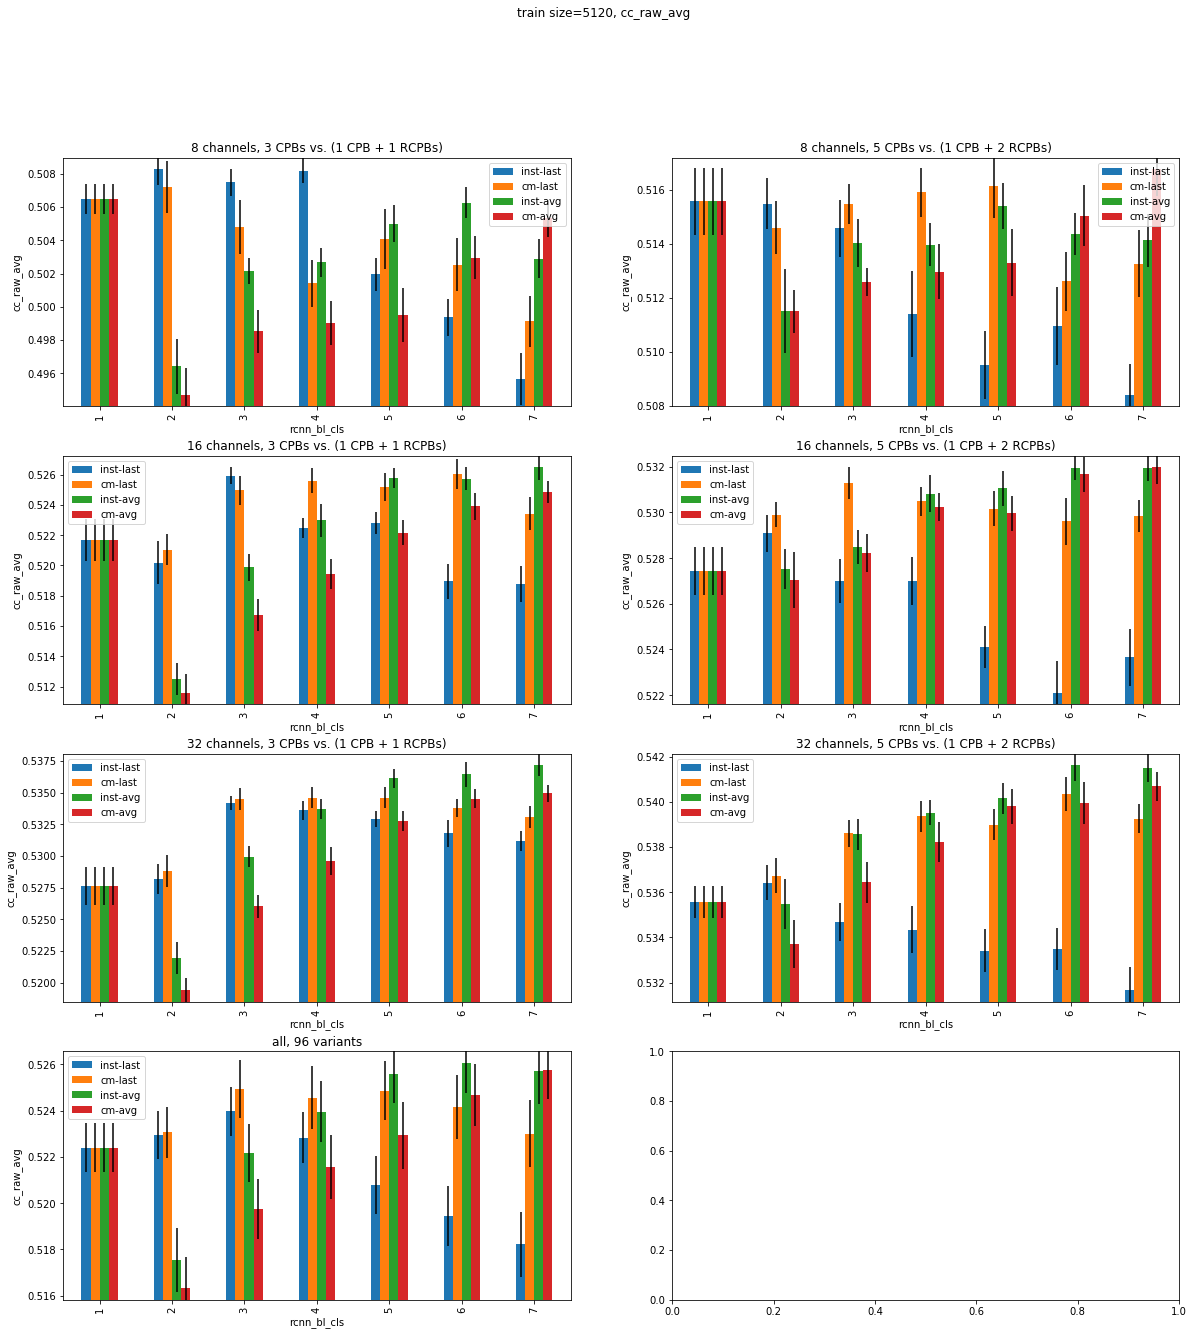

In [9]:
main_loop(df_main_result)